# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


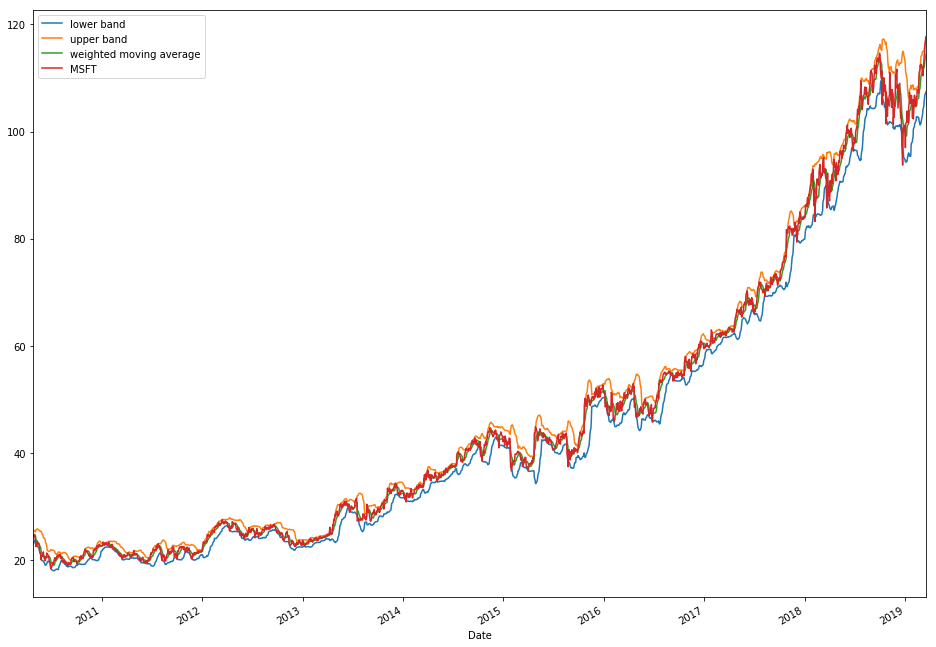

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
   
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    #scale adjusted price to 100
    scaled_df[adjclose] = scaled_df[adjclose].apply(lambda x: x*100)

    
    y_adj_close_list.append(scaled_df[adjclose])
    scaled_df = scaled_df.drop(columns=adjclose)
    
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


0         6.232732
1         6.281071
2         6.353582
3         5.982979
4         6.240790
5         5.652660
6         5.427072
7         4.726149
8         4.105787
9         4.693921
10        4.645576
11        5.096754
12        4.935621
13        4.685865
14        4.693921
15        4.523967
16        4.232612
17        3.318116
18        3.099600
19        2.638310
20        2.476448
21        1.618589
22        2.419793
23        2.257935
24        2.330771
25        2.792076
26        3.115788
27        2.249843
28        1.845195
29        1.699525
           ...    
2209     89.024115
2210     87.829382
2211     87.066355
2212     87.467954
2213     87.046286
2214     88.692802
2215     88.612478
2216     88.702841
2217     90.028084
2218     89.977883
2219     89.413259
2220     91.691931
2221     93.264816
2222     93.889933
2223     94.666298
2224     94.474726
2225     94.333570
2226     94.837701
2227     94.565474
2228     94.000842
2229     94.051258
2230     92.

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [9]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    linear_reg_predictions = []
    svm_linear_predictions = []
    svm_poly_predictions = []
    lstm_predictions = []
    y_actuals = []
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)
        linear_reg_predictions.append(linear_y_predict)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)
        svm_linear_predictions.append(svm_linear_y_predict)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)
        svm_poly_predictions.append(svm_polynomial_y_predict)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 1000)
        lstm_y_predict = lstm_model.predict(testX)
        lstm_predictions.append(lstm_y_predict)


        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[index])

        results_dataframe = results_dataframe.append(df)
        y_actuals.append(y_test)
    return results_dataframe, linear_reg_predictions, svm_linear_predictions, \
                svm_poly_predictions, lstm_predictions, y_actuals

In [10]:
results_different_models , linear_reg_predictions, svm_linear_predictions, \
svm_poly_predictions, lstm_predictions, y_actuals = drive_test(True)
result_same_models, a,b,c,d,e= drive_test(False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1791/1791 [==============================] - 0s 79us/step - loss: 51.8794 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 11us/step - loss: 2.0283 - acc: 5.5835e-04
Epoch 3/100
1791/1791 [==============================] - 0s 11us/step - loss: 2.0068 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.9487 - acc: 5.5835e-04
Epoch 5/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.8999 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.8304 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 12us/step - loss: 1.7872 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [====================

1791/1791 [==============================] - 0s 11us/step - loss: 0.9766 - acc: 0.0000e+00
Epoch 71/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9665 - acc: 0.0000e+00
Epoch 72/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9780 - acc: 0.0000e+00
Epoch 73/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9811 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9744 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9924 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9474 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9951 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9934 - acc: 0.0000e+00
Epoch 79/100
1791/1791 [==============================] - 0s 11us/step - loss

1791/1791 [==============================] - 0s 33us/step - loss: 25.8118
Epoch 58/1000
1791/1791 [==============================] - 0s 33us/step - loss: 27.2072
Epoch 59/1000
1791/1791 [==============================] - 0s 33us/step - loss: 27.0422
Epoch 60/1000
1791/1791 [==============================] - 0s 33us/step - loss: 29.5545
Epoch 61/1000
1791/1791 [==============================] - 0s 32us/step - loss: 26.7766
Epoch 62/1000
1791/1791 [==============================] - 0s 33us/step - loss: 25.2854
Epoch 63/1000
1791/1791 [==============================] - 0s 33us/step - loss: 28.0869
Epoch 64/1000
1791/1791 [==============================] - 0s 33us/step - loss: 26.1260
Epoch 65/1000
1791/1791 [==============================] - 0s 33us/step - loss: 24.2116
Epoch 66/1000
1791/1791 [==============================] - 0s 33us/step - loss: 27.7694
Epoch 67/1000
1791/1791 [==============================] - 0s 33us/step - loss: 27.5012
Epoch 68/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 34us/step - loss: 25.5358
Epoch 150/1000
1791/1791 [==============================] - 0s 34us/step - loss: 23.8445
Epoch 151/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.8239
Epoch 152/1000
1791/1791 [==============================] - 0s 35us/step - loss: 25.2092
Epoch 153/1000
1791/1791 [==============================] - 0s 33us/step - loss: 26.2266
Epoch 154/1000
1791/1791 [==============================] - 0s 33us/step - loss: 27.1544
Epoch 155/1000
1791/1791 [==============================] - 0s 35us/step - loss: 23.8270
Epoch 156/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.8652
Epoch 157/1000
1791/1791 [==============================] - 0s 35us/step - loss: 26.0457
Epoch 158/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.5514
Epoch 159/1000
1791/1791 [==============================] - 0s 35us/step - loss: 24.0434
Epoch 160/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 23.5157
Epoch 242/1000
1791/1791 [==============================] - 0s 34us/step - loss: 23.5053
Epoch 243/1000
1791/1791 [==============================] - 0s 33us/step - loss: 24.7686
Epoch 244/1000
1791/1791 [==============================] - 0s 33us/step - loss: 23.5699
Epoch 245/1000
1791/1791 [==============================] - 0s 35us/step - loss: 25.1765
Epoch 246/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.8077
Epoch 247/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.9545
Epoch 248/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.7396
Epoch 249/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.1383
Epoch 250/1000
1791/1791 [==============================] - 0s 33us/step - loss: 26.3063
Epoch 251/1000
1791/1791 [==============================] - 0s 33us/step - loss: 23.6481
Epoch 252/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 21.5310
Epoch 334/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.6708
Epoch 335/1000
1791/1791 [==============================] - 0s 34us/step - loss: 23.3014
Epoch 336/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.6579
Epoch 337/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.8682
Epoch 338/1000
1791/1791 [==============================] - 0s 33us/step - loss: 23.0213
Epoch 339/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.1513
Epoch 340/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.2532
Epoch 341/1000
1791/1791 [==============================] - 0s 33us/step - loss: 24.7140
Epoch 342/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.5130
Epoch 343/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.1925
Epoch 344/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 20.5868
Epoch 426/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.4148
Epoch 427/1000
1791/1791 [==============================] - 0s 32us/step - loss: 20.8320
Epoch 428/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.0405
Epoch 429/1000
1791/1791 [==============================] - 0s 32us/step - loss: 21.1952
Epoch 430/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.0412
Epoch 431/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.6718
Epoch 432/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.0618
Epoch 433/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.1535
Epoch 434/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4269
Epoch 435/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.8643
Epoch 436/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 20.7527
Epoch 518/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.8336
Epoch 519/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.7263
Epoch 520/1000
1791/1791 [==============================] - 0s 32us/step - loss: 19.4888
Epoch 521/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.7966
Epoch 522/1000
1791/1791 [==============================] - 0s 32us/step - loss: 19.3041
Epoch 523/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1860
Epoch 524/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.0346
Epoch 525/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.0866
Epoch 526/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.9541
Epoch 527/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.6303
Epoch 528/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 19.2110
Epoch 610/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.6459
Epoch 611/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.3790
Epoch 612/1000
1791/1791 [==============================] - 0s 32us/step - loss: 20.5701
Epoch 613/1000
1791/1791 [==============================] - 0s 33us/step - loss: 18.4625
Epoch 614/1000
1791/1791 [==============================] - 0s 32us/step - loss: 18.0380
Epoch 615/1000
1791/1791 [==============================] - 0s 32us/step - loss: 19.5140
Epoch 616/1000
1791/1791 [==============================] - 0s 33us/step - loss: 18.8960
Epoch 617/1000
1791/1791 [==============================] - 0s 32us/step - loss: 17.7962
Epoch 618/1000
1791/1791 [==============================] - 0s 33us/step - loss: 18.8533
Epoch 619/1000
1791/1791 [==============================] - 0s 32us/step - loss: 18.7936
Epoch 620/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 16.9126
Epoch 702/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.8364
Epoch 703/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.3600
Epoch 704/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.3306
Epoch 705/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.6464
Epoch 706/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.6708
Epoch 707/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.1965
Epoch 708/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.8276
Epoch 709/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.6048
Epoch 710/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.6665
Epoch 711/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.9373
Epoch 712/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 10.6236
Epoch 794/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.8045
Epoch 795/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.5987
Epoch 796/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.4170
Epoch 797/1000
1791/1791 [==============================] - 0s 32us/step - loss: 11.3063
Epoch 798/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.0620
Epoch 799/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.1748
Epoch 800/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.2081
Epoch 801/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.2329
Epoch 802/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.1546
Epoch 803/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.7951
Epoch 804/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 9.9125
Epoch 886/1000
1791/1791 [==============================] - 0s 33us/step - loss: 8.8996
Epoch 887/1000
1791/1791 [==============================] - 0s 32us/step - loss: 9.6797
Epoch 888/1000
1791/1791 [==============================] - 0s 33us/step - loss: 9.6440
Epoch 889/1000
1791/1791 [==============================] - 0s 32us/step - loss: 9.3802
Epoch 890/1000
1791/1791 [==============================] - 0s 33us/step - loss: 9.1556
Epoch 891/1000
1791/1791 [==============================] - 0s 32us/step - loss: 9.6237
Epoch 892/1000
1791/1791 [==============================] - 0s 32us/step - loss: 9.5617
Epoch 893/1000
1791/1791 [==============================] - 0s 32us/step - loss: 9.9547
Epoch 894/1000
1791/1791 [==============================] - 0s 33us/step - loss: 10.0800
Epoch 895/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.1618
Epoch 896/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 33us/step - loss: 6.6743
Epoch 979/1000
1791/1791 [==============================] - 0s 34us/step - loss: 7.7239
Epoch 980/1000
1791/1791 [==============================] - 0s 33us/step - loss: 7.9141
Epoch 981/1000
1791/1791 [==============================] - 0s 33us/step - loss: 7.3934
Epoch 982/1000
1791/1791 [==============================] - 0s 32us/step - loss: 7.1113
Epoch 983/1000
1791/1791 [==============================] - 0s 33us/step - loss: 6.8087
Epoch 984/1000
1791/1791 [==============================] - 0s 33us/step - loss: 6.7702
Epoch 985/1000
1791/1791 [==============================] - 0s 33us/step - loss: 6.5815
Epoch 986/1000
1791/1791 [==============================] - 0s 33us/step - loss: 8.3255
Epoch 987/1000
1791/1791 [==============================] - 0s 33us/step - loss: 6.6702
Epoch 988/1000
1791/1791 [==============================] - 0s 33us/step - loss: 7.2902
Epoch 989/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 11us/step - loss: 0.2267 - acc: 5.5835e-04
Epoch 57/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2349 - acc: 0.0000e+00
Epoch 58/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2286 - acc: 0.0000e+00
Epoch 59/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2238 - acc: 0.0000e+00
Epoch 60/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2238 - acc: 0.0000e+00
Epoch 61/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2204 - acc: 0.0000e+00
Epoch 62/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2255 - acc: 0.0000e+00
Epoch 63/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2193 - acc: 0.0000e+00
Epoch 64/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.2202 - acc: 0.0000e+00
Epoch 65/100
1791/1791 [==============================] - 0s 11us/step - loss

Epoch 41/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.5569
Epoch 42/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.6441
Epoch 43/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0749
Epoch 44/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.0099
Epoch 45/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.8010
Epoch 46/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.8751
Epoch 47/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2931
Epoch 48/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.8929
Epoch 49/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.6021
Epoch 50/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.5192
Epoch 51/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0976
Epoch 52/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 34us/step - loss: 15.5952
Epoch 134/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.3049
Epoch 135/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0975
Epoch 136/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0884
Epoch 137/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.3296
Epoch 138/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.6096
Epoch 139/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8171
Epoch 140/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.7300
Epoch 141/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.3067
Epoch 142/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.3866
Epoch 143/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.7784
Epoch 144/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 16.1831
Epoch 226/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.1150
Epoch 227/1000
1791/1791 [==============================] - 0s 33us/step - loss: 16.2213
Epoch 228/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.0358
Epoch 229/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.4832
Epoch 230/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.6579
Epoch 231/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2920
Epoch 232/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.2914
Epoch 233/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.3133
Epoch 234/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2617
Epoch 235/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.9489
Epoch 236/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 15.9207
Epoch 318/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.7889
Epoch 319/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.9228
Epoch 320/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.9925
Epoch 321/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.3175
Epoch 322/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.8915
Epoch 323/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1000
Epoch 324/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.9722
Epoch 325/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.7444
Epoch 326/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.9451
Epoch 327/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.7053
Epoch 328/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 14.5467
Epoch 410/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.9385
Epoch 411/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.4803
Epoch 412/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.6609
Epoch 413/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.1650
Epoch 414/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.5471
Epoch 415/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.0990
Epoch 416/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.7512
Epoch 417/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.1366
Epoch 418/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.4765
Epoch 419/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3628
Epoch 420/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 14.7185
Epoch 502/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.7701
Epoch 503/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.5604
Epoch 504/1000
1791/1791 [==============================] - 0s 33us/step - loss: 15.0122
Epoch 505/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.9011
Epoch 506/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.3818
Epoch 507/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.7370
Epoch 508/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.2370
Epoch 509/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.2727
Epoch 510/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3258
Epoch 511/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.6524
Epoch 512/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 12.5259
Epoch 594/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.4842
Epoch 595/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.3241
Epoch 596/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.4350
Epoch 597/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.5213
Epoch 598/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.5534
Epoch 599/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.2824
Epoch 600/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3158
Epoch 601/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.3393
Epoch 602/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.7606
Epoch 603/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.6588
Epoch 604/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 13.6960
Epoch 686/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.6215
Epoch 687/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.1528
Epoch 688/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.9001
Epoch 689/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.2045
Epoch 690/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.6938
Epoch 691/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.0962
Epoch 692/1000
1791/1791 [==============================] - 0s 33us/step - loss: 14.5384
Epoch 693/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.3703
Epoch 694/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.5704
Epoch 695/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.3931
Epoch 696/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 11.9437
Epoch 778/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.2545
Epoch 779/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.4169
Epoch 780/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.1693
Epoch 781/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.5228
Epoch 782/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.3169
Epoch 783/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.4187
Epoch 784/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.5625
Epoch 785/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.5514
Epoch 786/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.5292
Epoch 787/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.1642
Epoch 788/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 12.6984
Epoch 870/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.9728
Epoch 871/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.5725
Epoch 872/1000
1791/1791 [==============================] - 0s 33us/step - loss: 13.0453
Epoch 873/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.2607
Epoch 874/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.4057
Epoch 875/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.0915
Epoch 876/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.7422
Epoch 877/1000
1791/1791 [==============================] - 0s 33us/step - loss: 12.6521
Epoch 878/1000
1791/1791 [==============================] - 0s 35us/step - loss: 12.7612
Epoch 879/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.1950
Epoch 880/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 11.9754
Epoch 962/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.7550
Epoch 963/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.4419
Epoch 964/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.7096
Epoch 965/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.1636
Epoch 966/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.1481
Epoch 967/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.2937
Epoch 968/1000
1791/1791 [==============================] - 0s 33us/step - loss: 10.3962
Epoch 969/1000
1791/1791 [==============================] - 0s 33us/step - loss: 10.5134
Epoch 970/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.9110
Epoch 971/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.7672
Epoch 972/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 12us/step - loss: 0.6503 - acc: 0.0000e+00
Epoch 43/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6334 - acc: 0.0000e+00
Epoch 44/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6708 - acc: 0.0000e+00
Epoch 45/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.6607 - acc: 0.0000e+00
Epoch 46/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6553 - acc: 0.0000e+00
Epoch 47/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6438 - acc: 0.0000e+00
Epoch 48/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6594 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.6681 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.6459 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 12us/step - loss

1791/1791 [==============================] - 0s 34us/step - loss: 26.2339
Epoch 25/1000
1791/1791 [==============================] - 0s 35us/step - loss: 28.7079
Epoch 26/1000
1791/1791 [==============================] - 0s 33us/step - loss: 25.0928
Epoch 27/1000
1791/1791 [==============================] - 0s 34us/step - loss: 25.8751
Epoch 28/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.1678
Epoch 29/1000
1791/1791 [==============================] - 0s 34us/step - loss: 27.1522
Epoch 30/1000
1791/1791 [==============================] - 0s 33us/step - loss: 26.9500
Epoch 31/1000
1791/1791 [==============================] - 0s 34us/step - loss: 25.0684
Epoch 32/1000
1791/1791 [==============================] - 0s 35us/step - loss: 25.5065
Epoch 33/1000
1791/1791 [==============================] - 0s 33us/step - loss: 24.8622
Epoch 34/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.3635
Epoch 35/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 34us/step - loss: 23.8074
Epoch 118/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.2149
Epoch 119/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.3651
Epoch 120/1000
1791/1791 [==============================] - 0s 33us/step - loss: 25.0556
Epoch 121/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.1819
Epoch 122/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.7054
Epoch 123/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.7259
Epoch 124/1000
1791/1791 [==============================] - 0s 33us/step - loss: 25.5074
Epoch 125/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.4932
Epoch 126/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.3926
Epoch 127/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.7704
Epoch 128/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 21.3432
Epoch 210/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.7001
Epoch 211/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.3569
Epoch 212/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.9193
Epoch 213/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.5574
Epoch 214/1000
1791/1791 [==============================] - 0s 33us/step - loss: 23.2388
Epoch 215/1000
1791/1791 [==============================] - 0s 34us/step - loss: 23.5310
Epoch 216/1000
1791/1791 [==============================] - 0s 33us/step - loss: 23.4912
Epoch 217/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.4307
Epoch 218/1000
1791/1791 [==============================] - 0s 34us/step - loss: 27.4495
Epoch 219/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.7951
Epoch 220/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 21.1840
Epoch 302/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.4444
Epoch 303/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.7035
Epoch 304/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.5135
Epoch 305/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.9671
Epoch 306/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.3289
Epoch 307/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.9540
Epoch 308/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.1468
Epoch 309/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.4690
Epoch 310/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.9805
Epoch 311/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.2477
Epoch 312/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 19.9675
Epoch 394/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4940
Epoch 395/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.7704
Epoch 396/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.6685
Epoch 397/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.9213
Epoch 398/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.9087
Epoch 399/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.1216
Epoch 400/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3488
Epoch 401/1000
1791/1791 [==============================] - 0s 33us/step - loss: 22.0180
Epoch 402/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.2122
Epoch 403/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.5215
Epoch 404/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 33us/step - loss: 19.1296
Epoch 486/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.1193
Epoch 487/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.3900
Epoch 488/1000
1791/1791 [==============================] - 0s 33us/step - loss: 21.3627
Epoch 489/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.0619
Epoch 490/1000
1791/1791 [==============================] - 0s 32us/step - loss: 19.9933
Epoch 491/1000
1791/1791 [==============================] - 0s 32us/step - loss: 18.9076
Epoch 492/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.2183
Epoch 493/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.1270
Epoch 494/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.6872
Epoch 495/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.6919
Epoch 496/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 18.5448
Epoch 578/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.4625
Epoch 579/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.6695
Epoch 580/1000
1791/1791 [==============================] - 0s 33us/step - loss: 18.8470
Epoch 581/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.3072
Epoch 582/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.4705
Epoch 583/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.9613
Epoch 584/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.5236
Epoch 585/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.2747
Epoch 586/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4871
Epoch 587/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.5608
Epoch 588/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 18.4337
Epoch 670/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.3817
Epoch 671/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.2163
Epoch 672/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0815
Epoch 673/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.6484
Epoch 674/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.0904
Epoch 675/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.2510
Epoch 676/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3941
Epoch 677/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.8190
Epoch 678/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.5506
Epoch 679/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.0446
Epoch 680/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.3600
Epoch 762/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.0039
Epoch 763/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.0254
Epoch 764/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.6816
Epoch 765/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3615
Epoch 766/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.7955
Epoch 767/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.1234
Epoch 768/1000
1791/1791 [==============================] - 0s 33us/step - loss: 20.7646
Epoch 769/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.2179
Epoch 770/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3365
Epoch 771/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.9397
Epoch 772/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 17.1485
Epoch 854/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6683
Epoch 855/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.8024
Epoch 856/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.7658
Epoch 857/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.2574
Epoch 858/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.8680
Epoch 859/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.0800
Epoch 860/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.5398
Epoch 861/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.1841
Epoch 862/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0114
Epoch 863/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.4383
Epoch 864/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 18.0501
Epoch 946/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.4403
Epoch 947/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.5527
Epoch 948/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.3939
Epoch 949/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.3178
Epoch 950/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.5281
Epoch 951/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2200
Epoch 952/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5531
Epoch 953/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.1637
Epoch 954/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9181
Epoch 955/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5390
Epoch 956/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 12us/step - loss: 0.9717 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9798 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9732 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9572 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9714 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9632 - acc: 0.0000e+00
Epoch 34/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.9637 - acc: 0.0000e+00
Epoch 35/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.9636 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.9692 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 12us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 343.1903
Epoch 8/1000
1791/1791 [==============================] - 0s 35us/step - loss: 268.0176
Epoch 9/1000
1791/1791 [==============================] - 0s 38us/step - loss: 218.9148
Epoch 10/1000
1791/1791 [==============================] - 0s 36us/step - loss: 176.3717
Epoch 11/1000
1791/1791 [==============================] - 0s 37us/step - loss: 139.5795
Epoch 12/1000
1791/1791 [==============================] - 0s 35us/step - loss: 109.2082
Epoch 13/1000
1791/1791 [==============================] - 0s 35us/step - loss: 86.0699
Epoch 14/1000
1791/1791 [==============================] - 0s 35us/step - loss: 67.0355
Epoch 15/1000
1791/1791 [==============================] - 0s 35us/step - loss: 53.0839
Epoch 16/1000
1791/1791 [==============================] - 0s 35us/step - loss: 45.4024
Epoch 17/1000
1791/1791 [==============================] - 0s 35us/step - loss: 39.3910
Epoch 18/1000
1791/1791 [=================

1791/1791 [==============================] - 0s 34us/step - loss: 20.8348
Epoch 101/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.1589
Epoch 102/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.4237
Epoch 103/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.8043
Epoch 104/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.8196
Epoch 105/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.6342
Epoch 106/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.6837
Epoch 107/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.6146
Epoch 108/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.9383
Epoch 109/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3448
Epoch 110/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.8378
Epoch 111/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 20.7910
Epoch 193/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.2501
Epoch 194/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.8925
Epoch 195/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.9617
Epoch 196/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.0470
Epoch 197/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.7421
Epoch 198/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.4879
Epoch 199/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2660
Epoch 200/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.2787
Epoch 201/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.4294
Epoch 202/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.1646
Epoch 203/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 22.9589
Epoch 285/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3369
Epoch 286/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.2626
Epoch 287/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.8487
Epoch 288/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.0528
Epoch 289/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.9798
Epoch 290/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.8382
Epoch 291/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.8345
Epoch 292/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.0014
Epoch 293/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.9954
Epoch 294/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.9081
Epoch 295/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 18.1080
Epoch 377/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0043
Epoch 378/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.4775
Epoch 379/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.6639
Epoch 380/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.8893
Epoch 381/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.9445
Epoch 382/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.0455
Epoch 383/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.0375
Epoch 384/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.2221
Epoch 385/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.9671
Epoch 386/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.7767
Epoch 387/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 18.5337
Epoch 469/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0434
Epoch 470/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8879
Epoch 471/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0862
Epoch 472/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0744
Epoch 473/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1394
Epoch 474/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0368
Epoch 475/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1554
Epoch 476/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1156
Epoch 477/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.9823
Epoch 478/1000
1791/1791 [==============================] - 0s 33us/step - loss: 17.1471
Epoch 479/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 19.7409
Epoch 561/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.9099
Epoch 562/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4244
Epoch 563/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.2293
Epoch 564/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.0628
Epoch 565/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.8343
Epoch 566/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.7149
Epoch 567/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.1663
Epoch 568/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.2056
Epoch 569/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.9343
Epoch 570/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2846
Epoch 571/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 16.1638
Epoch 653/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.6189
Epoch 654/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.8089
Epoch 655/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.9039
Epoch 656/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8953
Epoch 657/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0433
Epoch 658/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.7451
Epoch 659/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.3161
Epoch 660/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.8830
Epoch 661/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.5807
Epoch 662/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.9851
Epoch 663/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 14.5324
Epoch 745/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.7298
Epoch 746/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.8999
Epoch 747/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.4738
Epoch 748/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.5962
Epoch 749/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.5264
Epoch 750/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5534
Epoch 751/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.4494
Epoch 752/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.0205
Epoch 753/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.3393
Epoch 754/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.4323
Epoch 755/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 11.6176
Epoch 837/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.2986
Epoch 838/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.8345
Epoch 839/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.3330
Epoch 840/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.2051
Epoch 841/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.2352
Epoch 842/1000
1791/1791 [==============================] - 0s 33us/step - loss: 11.7432
Epoch 843/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.3091
Epoch 844/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.7148
Epoch 845/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.3844
Epoch 846/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.6767
Epoch 847/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 9.3957
Epoch 929/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.3169
Epoch 930/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.6997
Epoch 931/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.6573
Epoch 932/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.2843
Epoch 933/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.3455
Epoch 934/1000
1791/1791 [==============================] - 0s 33us/step - loss: 9.4373
Epoch 935/1000
1791/1791 [==============================] - 0s 33us/step - loss: 8.2210
Epoch 936/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.6949
Epoch 937/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.5967
Epoch 938/1000
1791/1791 [==============================] - 0s 33us/step - loss: 9.2905
Epoch 939/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 30us/step - loss: 0.2384 - acc: 0.0011
Epoch 15/100
1791/1791 [==============================] - 0s 29us/step - loss: 0.2424 - acc: 5.5835e-04
Epoch 16/100
1791/1791 [==============================] - 0s 31us/step - loss: 0.2273 - acc: 5.5835e-04
Epoch 17/100
1791/1791 [==============================] - 0s 29us/step - loss: 0.2354 - acc: 5.5835e-04
Epoch 18/100
1791/1791 [==============================] - 0s 20us/step - loss: 0.2309 - acc: 5.5835e-04
Epoch 19/100
1791/1791 [==============================] - 0s 20us/step - loss: 0.2269 - acc: 5.5835e-04
Epoch 20/100
1791/1791 [==============================] - 0s 20us/step - loss: 0.2459 - acc: 0.0000e+00
Epoch 21/100
1791/1791 [==============================] - 0s 20us/step - loss: 0.2343 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.2303 - acc: 0.0000e+00
Epoch 23/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.

1791/1791 [==============================] - 0s 26us/step - loss: 0.1982 - acc: 0.0011
Epoch 94/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2048 - acc: 5.5835e-04
Epoch 95/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.1969 - acc: 5.5835e-04
Epoch 96/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2075 - acc: 0.0011
Epoch 97/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2055 - acc: 5.5835e-04
Epoch 98/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2021 - acc: 5.5835e-04
Epoch 99/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2049 - acc: 0.0011
Epoch 100/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.2010 - acc: 0.0011
Epoch 1/1000
1791/1791 [==============================] - 1s 400us/step - loss: 1642.6748
Epoch 2/1000
1791/1791 [==============================] - 0s 34us/step - loss: 1475.0523
Epoch 3/1000
1791

1791/1791 [==============================] - 0s 37us/step - loss: 25.2961
Epoch 85/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.3088
Epoch 86/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.6749
Epoch 87/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.4198
Epoch 88/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.0520
Epoch 89/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.0482
Epoch 90/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.3501
Epoch 91/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.1868
Epoch 92/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.6788
Epoch 93/1000
1791/1791 [==============================] - 0s 34us/step - loss: 25.3181
Epoch 94/1000
1791/1791 [==============================] - 0s 34us/step - loss: 24.3371
Epoch 95/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 34us/step - loss: 22.1907
Epoch 177/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.5217
Epoch 178/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.5807
Epoch 179/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.2920
Epoch 180/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.2236
Epoch 181/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4281
Epoch 182/1000
1791/1791 [==============================] - 0s 33us/step - loss: 19.5348
Epoch 183/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3934
Epoch 184/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.6735
Epoch 185/1000
1791/1791 [==============================] - 0s 34us/step - loss: 21.0765
Epoch 186/1000
1791/1791 [==============================] - 0s 34us/step - loss: 22.1233
Epoch 187/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 20.6725
Epoch 269/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.6159
Epoch 270/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4758
Epoch 271/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3769
Epoch 272/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.9025
Epoch 273/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3519
Epoch 274/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4059
Epoch 275/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1838
Epoch 276/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.1033
Epoch 277/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.5725
Epoch 278/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.3937
Epoch 279/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 17.1396
Epoch 361/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.5760
Epoch 362/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.1720
Epoch 363/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0532
Epoch 364/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.9129
Epoch 365/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.9566
Epoch 366/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.8659
Epoch 367/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.4394
Epoch 368/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.3701
Epoch 369/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.2242
Epoch 370/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.1208
Epoch 371/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.1250
Epoch 453/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.9282
Epoch 454/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.2371
Epoch 455/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.6664
Epoch 456/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0366
Epoch 457/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.1594
Epoch 458/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.1118
Epoch 459/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4851
Epoch 460/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.2219
Epoch 461/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.9762
Epoch 462/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3723
Epoch 463/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 17.0034
Epoch 545/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.3845
Epoch 546/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.4697
Epoch 547/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.3618
Epoch 548/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1611
Epoch 549/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.1124
Epoch 550/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0957
Epoch 551/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.9206
Epoch 552/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.8940
Epoch 553/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.1450
Epoch 554/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.3548
Epoch 555/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 15.2807
Epoch 637/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7159
Epoch 638/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1980
Epoch 639/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.1267
Epoch 640/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.3816
Epoch 641/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.5294
Epoch 642/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.5762
Epoch 643/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8200
Epoch 644/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.3746
Epoch 645/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1924
Epoch 646/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.9049
Epoch 647/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 17.8619
Epoch 729/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8562
Epoch 730/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.4794
Epoch 731/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.3649
Epoch 732/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.9321
Epoch 733/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.8874
Epoch 734/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.1524
Epoch 735/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.9496
Epoch 736/1000
1791/1791 [==============================] - 0s 43us/step - loss: 15.6072
Epoch 737/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.2777
Epoch 738/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.8421
Epoch 739/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 15.5759
Epoch 821/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2766
Epoch 822/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.8466
Epoch 823/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.1434
Epoch 824/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0812
Epoch 825/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.5152
Epoch 826/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.8815
Epoch 827/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2478
Epoch 828/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.2845
Epoch 829/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.5726
Epoch 830/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.0977
Epoch 831/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 15.8330
Epoch 913/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.1888
Epoch 914/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.4983
Epoch 915/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8133
Epoch 916/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.4665
Epoch 917/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.0796
Epoch 918/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.4637
Epoch 919/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.6122
Epoch 920/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.4595
Epoch 921/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.9109
Epoch 922/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.9806
Epoch 923/1000
1791/1791 [==========

Epoch 1/100
1791/1791 [==============================] - 1s 318us/step - loss: 41.2599 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.3451 - acc: 5.5835e-04
Epoch 3/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.3349 - acc: 5.5835e-04
Epoch 4/100
1791/1791 [==============================] - 0s 13us/step - loss: 0.3363 - acc: 5.5835e-04
Epoch 5/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.3238 - acc: 5.5835e-04
Epoch 6/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.3256 - acc: 5.5835e-04
Epoch 7/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.3216 - acc: 5.5835e-04
Epoch 8/100
1791/1791 [==============================] - 0s 21us/step - loss: 0.3145 - acc: 5.5835e-04
Epoch 9/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.3150 - acc: 5.5835e-04
Epoch 10/100
1791/1791 [==============================] - 0s 23us/step 

1791/1791 [==============================] - 0s 38us/step - loss: 0.2845 - acc: 5.5835e-04
Epoch 80/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2767 - acc: 5.5835e-04
Epoch 81/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2757 - acc: 5.5835e-04
Epoch 82/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2792 - acc: 5.5835e-04
Epoch 83/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.2853 - acc: 5.5835e-04
Epoch 84/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.2786 - acc: 5.5835e-04
Epoch 85/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.2812 - acc: 5.5835e-04
Epoch 86/100
1791/1791 [==============================] - 0s 20us/step - loss: 0.2780 - acc: 5.5835e-04
Epoch 87/100
1791/1791 [==============================] - 0s 23us/step - loss: 0.2748 - acc: 5.5835e-04
Epoch 88/100
1791/1791 [==============================] - 0s 22us/step - loss

1791/1791 [==============================] - 0s 34us/step - loss: 21.5379
Epoch 69/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.2510
Epoch 70/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0163
Epoch 71/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.8040
Epoch 72/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.9235
Epoch 73/1000
1791/1791 [==============================] - 0s 35us/step - loss: 24.1637
Epoch 74/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.7052
Epoch 75/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.8229
Epoch 76/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.9290
Epoch 77/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.7326
Epoch 78/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.7300
Epoch 79/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 34us/step - loss: 18.7590
Epoch 161/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.8942
Epoch 162/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.4977
Epoch 163/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.3017
Epoch 164/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.6966
Epoch 165/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.1685
Epoch 166/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.4444
Epoch 167/1000
1791/1791 [==============================] - 0s 34us/step - loss: 19.3877
Epoch 168/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3066
Epoch 169/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.5517
Epoch 170/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.1540
Epoch 171/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 19.1240
Epoch 253/1000
1791/1791 [==============================] - 0s 34us/step - loss: 20.1551
Epoch 254/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4952
Epoch 255/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.0773
Epoch 256/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.7523
Epoch 257/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.9076
Epoch 258/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1283
Epoch 259/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.7600
Epoch 260/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.2463
Epoch 261/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4284
Epoch 262/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.0639
Epoch 263/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.1581
Epoch 345/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.6803
Epoch 346/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2617
Epoch 347/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.7257
Epoch 348/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.0039
Epoch 349/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7563
Epoch 350/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.9532
Epoch 351/1000
1791/1791 [==============================] - 0s 34us/step - loss: 18.4094
Epoch 352/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.4900
Epoch 353/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7700
Epoch 354/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.9287
Epoch 355/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.1586
Epoch 437/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1366
Epoch 438/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.6149
Epoch 439/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0796
Epoch 440/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.1225
Epoch 441/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.6157
Epoch 442/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.7931
Epoch 443/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.0059
Epoch 444/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.6540
Epoch 445/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.7776
Epoch 446/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8246
Epoch 447/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.4462
Epoch 529/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.9920
Epoch 530/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.7264
Epoch 531/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.1774
Epoch 532/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.4727
Epoch 533/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2196
Epoch 534/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4466
Epoch 535/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0261
Epoch 536/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3815
Epoch 537/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.7951
Epoch 538/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.4000
Epoch 539/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 15.3342
Epoch 621/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.4437
Epoch 622/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3936
Epoch 623/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.2317
Epoch 624/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.3765
Epoch 625/1000
1791/1791 [==============================] - 0s 34us/step - loss: 17.0832
Epoch 626/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.9758
Epoch 627/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.1226
Epoch 628/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.7239
Epoch 629/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.1115
Epoch 630/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8139
Epoch 631/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 16.4448
Epoch 713/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8469
Epoch 714/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.4228
Epoch 715/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.9076
Epoch 716/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.0629
Epoch 717/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.1479
Epoch 718/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.2164
Epoch 719/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.9606
Epoch 720/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8741
Epoch 721/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.9806
Epoch 722/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.4192
Epoch 723/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 16.4509
Epoch 805/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3980
Epoch 806/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.3658
Epoch 807/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.2709
Epoch 808/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8772
Epoch 809/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.8204
Epoch 810/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2135
Epoch 811/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.5990
Epoch 812/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.5429
Epoch 813/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.8975
Epoch 814/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.6045
Epoch 815/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 14.5422
Epoch 897/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8976
Epoch 898/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.7300
Epoch 899/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.7334
Epoch 900/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.0076
Epoch 901/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.9940
Epoch 902/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.5260
Epoch 903/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.2176
Epoch 904/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.0398
Epoch 905/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.1741
Epoch 906/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.6775
Epoch 907/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 16.0817
Epoch 989/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.8306
Epoch 990/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.5116
Epoch 991/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.8312
Epoch 992/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.6608
Epoch 993/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.9860
Epoch 994/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.8045
Epoch 995/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.6427
Epoch 996/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.2209
Epoch 997/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.6700
Epoch 998/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.4818
Epoch 999/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 30us/step - loss: 0.3187 - acc: 5.5835e-04
Epoch 66/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3232 - acc: 5.5835e-04
Epoch 67/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3209 - acc: 5.5835e-04
Epoch 68/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3120 - acc: 5.5835e-04
Epoch 69/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3198 - acc: 5.5835e-04
Epoch 70/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3156 - acc: 5.5835e-04
Epoch 71/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3066 - acc: 5.5835e-04
Epoch 72/100
1791/1791 [==============================] - 0s 26us/step - loss: 0.3125 - acc: 5.5835e-04
Epoch 73/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.3104 - acc: 5.5835e-04
Epoch 74/100
1791/1791 [==============================] - 0s 26us/step - loss

1791/1791 [==============================] - 0s 34us/step - loss: 17.4019
Epoch 52/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.9610
Epoch 53/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.7796
Epoch 54/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.1457
Epoch 55/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.5283
Epoch 56/1000
1791/1791 [==============================] - 0s 34us/step - loss: 16.3144
Epoch 57/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.8809
Epoch 58/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.3903
Epoch 59/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.0513
Epoch 60/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.7461
Epoch 61/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.2171
Epoch 62/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 34us/step - loss: 14.8780
Epoch 144/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3120
Epoch 145/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.1092
Epoch 146/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.7648
Epoch 147/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.2258
Epoch 148/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.7082
Epoch 149/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.4642
Epoch 150/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.1824
Epoch 151/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.9915
Epoch 152/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.0869
Epoch 153/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.5309
Epoch 154/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 12.4552
Epoch 236/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3799
Epoch 237/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.5866
Epoch 238/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.1583
Epoch 239/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.5750
Epoch 240/1000
1791/1791 [==============================] - 0s 35us/step - loss: 11.8061
Epoch 241/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.3199
Epoch 242/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.8874
Epoch 243/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.4105
Epoch 244/1000
1791/1791 [==============================] - 0s 34us/step - loss: 15.0991
Epoch 245/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.4968
Epoch 246/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 12.7394
Epoch 328/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.0303
Epoch 329/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.8870
Epoch 330/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.1296
Epoch 331/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.6660
Epoch 332/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.6997
Epoch 333/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.0244
Epoch 334/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.8986
Epoch 335/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.1368
Epoch 336/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.8503
Epoch 337/1000
1791/1791 [==============================] - 0s 34us/step - loss: 14.7079
Epoch 338/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 12.5342
Epoch 420/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.9861
Epoch 421/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.8602
Epoch 422/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.3745
Epoch 423/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.4971
Epoch 424/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.3820
Epoch 425/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9159
Epoch 426/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.2653
Epoch 427/1000
1791/1791 [==============================] - 0s 35us/step - loss: 11.1209
Epoch 428/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.8483
Epoch 429/1000
1791/1791 [==============================] - 0s 34us/step - loss: 13.2413
Epoch 430/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 11.8557
Epoch 512/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.7094
Epoch 513/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.4011
Epoch 514/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.6635
Epoch 515/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9186
Epoch 516/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.4891
Epoch 517/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.3039
Epoch 518/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.0023
Epoch 519/1000
1791/1791 [==============================] - 0s 34us/step - loss: 12.3186
Epoch 520/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.4763
Epoch 521/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.2978
Epoch 522/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 34us/step - loss: 10.4886
Epoch 604/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.3639
Epoch 605/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.7250
Epoch 606/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.8703
Epoch 607/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.8378
Epoch 608/1000
1791/1791 [==============================] - 0s 35us/step - loss: 13.1935
Epoch 609/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.8815
Epoch 610/1000
1791/1791 [==============================] - 0s 35us/step - loss: 11.2069
Epoch 611/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.3092
Epoch 612/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.4181
Epoch 613/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9472
Epoch 614/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 36us/step - loss: 10.7803
Epoch 696/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.3507
Epoch 697/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.4803
Epoch 698/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.4979
Epoch 699/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.8265
Epoch 700/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.4000
Epoch 701/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.9843
Epoch 702/1000
1791/1791 [==============================] - 0s 35us/step - loss: 11.0400
Epoch 703/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.1831
Epoch 704/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.3933
Epoch 705/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.5028
Epoch 706/1000
1791/1791 [============

1791/1791 [==============================] - 0s 34us/step - loss: 9.3277
Epoch 788/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.1506
Epoch 789/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9947
Epoch 790/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.0911
Epoch 791/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.5570
Epoch 792/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9185
Epoch 793/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.9206
Epoch 794/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.3315
Epoch 795/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.0548
Epoch 796/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.1925
Epoch 797/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.6867
Epoch 798/1000
1791/1791 [==============

1791/1791 [==============================] - 0s 34us/step - loss: 10.9665
Epoch 880/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.7693
Epoch 881/1000
1791/1791 [==============================] - 0s 34us/step - loss: 11.2698
Epoch 882/1000
1791/1791 [==============================] - 0s 35us/step - loss: 9.7196
Epoch 883/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.9458
Epoch 884/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.5951
Epoch 885/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.0870
Epoch 886/1000
1791/1791 [==============================] - 0s 34us/step - loss: 10.7234
Epoch 887/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.4605
Epoch 888/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.9028
Epoch 889/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.5759
Epoch 890/1000
1791/1791 [===============

1791/1791 [==============================] - 0s 34us/step - loss: 8.4077
Epoch 973/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.1241
Epoch 974/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.1378
Epoch 975/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.6071
Epoch 976/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.7344
Epoch 977/1000
1791/1791 [==============================] - 0s 34us/step - loss: 9.4302
Epoch 978/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.6901
Epoch 979/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.3326
Epoch 980/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.3063
Epoch 981/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.1581
Epoch 982/1000
1791/1791 [==============================] - 0s 34us/step - loss: 8.0403
Epoch 983/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 26us/step - loss: 1.1126 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 26us/step - loss: 1.1111 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1022 - acc: 0.0000e+00
Epoch 54/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1812 - acc: 5.5835e-04
Epoch 55/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1146 - acc: 5.5835e-04
Epoch 56/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1012 - acc: 5.5835e-04
Epoch 57/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1434 - acc: 0.0000e+00
Epoch 58/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.1682 - acc: 0.0000e+00
Epoch 59/100
1791/1791 [==============================] - 0s 27us/step - loss: 1.2165 - acc: 0.0000e+00
Epoch 60/100
1791/1791 [==============================] - 0s 27us/step - loss

Epoch 35/1000
1791/1791 [==============================] - 0s 36us/step - loss: 51.2250
Epoch 36/1000
1791/1791 [==============================] - 0s 35us/step - loss: 50.4060
Epoch 37/1000
1791/1791 [==============================] - 0s 35us/step - loss: 51.1765
Epoch 38/1000
1791/1791 [==============================] - 0s 36us/step - loss: 47.8857
Epoch 39/1000
1791/1791 [==============================] - 0s 35us/step - loss: 49.5789
Epoch 40/1000
1791/1791 [==============================] - 0s 35us/step - loss: 50.3371
Epoch 41/1000
1791/1791 [==============================] - 0s 37us/step - loss: 54.9153
Epoch 42/1000
1791/1791 [==============================] - 0s 35us/step - loss: 48.9487
Epoch 43/1000
1791/1791 [==============================] - 0s 35us/step - loss: 50.2118
Epoch 44/1000
1791/1791 [==============================] - 0s 35us/step - loss: 50.6494
Epoch 45/1000
1791/1791 [==============================] - 0s 35us/step - loss: 52.3476
Epoch 46/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 35us/step - loss: 54.4891
Epoch 128/1000
1791/1791 [==============================] - 0s 35us/step - loss: 46.0303
Epoch 129/1000
1791/1791 [==============================] - 0s 35us/step - loss: 51.3494
Epoch 130/1000
1791/1791 [==============================] - 0s 35us/step - loss: 50.1355
Epoch 131/1000
1791/1791 [==============================] - 0s 35us/step - loss: 47.4771
Epoch 132/1000
1791/1791 [==============================] - 0s 35us/step - loss: 49.7707
Epoch 133/1000
1791/1791 [==============================] - 0s 35us/step - loss: 51.3189
Epoch 134/1000
1791/1791 [==============================] - 0s 35us/step - loss: 54.2609
Epoch 135/1000
1791/1791 [==============================] - 0s 37us/step - loss: 53.4405
Epoch 136/1000
1791/1791 [==============================] - 0s 42us/step - loss: 53.5427
Epoch 137/1000
1791/1791 [==============================] - 0s 41us/step - loss: 48.7859
Epoch 138/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 49.8314
Epoch 220/1000
1791/1791 [==============================] - 0s 36us/step - loss: 48.7138
Epoch 221/1000
1791/1791 [==============================] - 0s 36us/step - loss: 50.2284
Epoch 222/1000
1791/1791 [==============================] - 0s 36us/step - loss: 48.6350
Epoch 223/1000
1791/1791 [==============================] - 0s 36us/step - loss: 50.2793
Epoch 224/1000
1791/1791 [==============================] - 0s 37us/step - loss: 51.2671
Epoch 225/1000
1791/1791 [==============================] - 0s 36us/step - loss: 50.8950
Epoch 226/1000
1791/1791 [==============================] - 0s 41us/step - loss: 48.1297
Epoch 227/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.1576
Epoch 228/1000
1791/1791 [==============================] - 0s 37us/step - loss: 51.6238
Epoch 229/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.3509
Epoch 230/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 49.3344
Epoch 312/1000
1791/1791 [==============================] - 0s 36us/step - loss: 50.4732
Epoch 313/1000
1791/1791 [==============================] - 0s 35us/step - loss: 46.3284
Epoch 314/1000
1791/1791 [==============================] - 0s 36us/step - loss: 45.9494
Epoch 315/1000
1791/1791 [==============================] - 0s 36us/step - loss: 51.7504
Epoch 316/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.2780
Epoch 317/1000
1791/1791 [==============================] - 0s 37us/step - loss: 47.7219
Epoch 318/1000
1791/1791 [==============================] - 0s 36us/step - loss: 46.2227
Epoch 319/1000
1791/1791 [==============================] - 0s 36us/step - loss: 47.2873
Epoch 320/1000
1791/1791 [==============================] - 0s 37us/step - loss: 45.8086
Epoch 321/1000
1791/1791 [==============================] - 0s 36us/step - loss: 45.8091
Epoch 322/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 46.7549
Epoch 404/1000
1791/1791 [==============================] - 0s 36us/step - loss: 47.9403
Epoch 405/1000
1791/1791 [==============================] - 0s 36us/step - loss: 46.6221
Epoch 406/1000
1791/1791 [==============================] - 0s 36us/step - loss: 44.3294
Epoch 407/1000
1791/1791 [==============================] - 0s 36us/step - loss: 44.2622
Epoch 408/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.9685
Epoch 409/1000
1791/1791 [==============================] - 0s 36us/step - loss: 44.6527
Epoch 410/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.3060
Epoch 411/1000
1791/1791 [==============================] - 0s 37us/step - loss: 43.3655
Epoch 412/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.3894
Epoch 413/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.4019
Epoch 414/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 40.9333
Epoch 496/1000
1791/1791 [==============================] - 0s 37us/step - loss: 40.6155
Epoch 497/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.6766
Epoch 498/1000
1791/1791 [==============================] - 0s 36us/step - loss: 40.2688
Epoch 499/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.9403
Epoch 500/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.6665
Epoch 501/1000
1791/1791 [==============================] - 0s 36us/step - loss: 40.6612
Epoch 502/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.8207
Epoch 503/1000
1791/1791 [==============================] - 0s 41us/step - loss: 38.3323
Epoch 504/1000
1791/1791 [==============================] - 0s 37us/step - loss: 37.9797
Epoch 505/1000
1791/1791 [==============================] - 0s 36us/step - loss: 40.1365
Epoch 506/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 28.6542
Epoch 588/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.4405
Epoch 589/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.2600
Epoch 590/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.0612
Epoch 591/1000
1791/1791 [==============================] - 0s 35us/step - loss: 29.8057
Epoch 592/1000
1791/1791 [==============================] - 0s 37us/step - loss: 32.0104
Epoch 593/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.0969
Epoch 594/1000
1791/1791 [==============================] - 0s 37us/step - loss: 30.6530
Epoch 595/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.1345
Epoch 596/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.8007
Epoch 597/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.9318
Epoch 598/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 23.0561
Epoch 680/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.5616
Epoch 681/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.5876
Epoch 682/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.5457
Epoch 683/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.0656
Epoch 684/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.6464
Epoch 685/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.8612
Epoch 686/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.4854
Epoch 687/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.1907
Epoch 688/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.3831
Epoch 689/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.5708
Epoch 690/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 16.2846
Epoch 772/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1641
Epoch 773/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.1655
Epoch 774/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2596
Epoch 775/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.1565
Epoch 776/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.5383
Epoch 777/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.6245
Epoch 778/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.4211
Epoch 779/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.1089
Epoch 780/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.7657
Epoch 781/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.0959
Epoch 782/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.7574
Epoch 864/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.7451
Epoch 865/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.5489
Epoch 866/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.4675
Epoch 867/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.5913
Epoch 868/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.4398
Epoch 869/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.7038
Epoch 870/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.4614
Epoch 871/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7573
Epoch 872/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2626
Epoch 873/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.2358
Epoch 874/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.2680
Epoch 956/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7578
Epoch 957/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.8174
Epoch 958/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.0785
Epoch 959/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4434
Epoch 960/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7242
Epoch 961/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9878
Epoch 962/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.1226
Epoch 963/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.1520
Epoch 964/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.1495
Epoch 965/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.8940
Epoch 966/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 14us/step - loss: 0.8204 - acc: 0.0000e+00
Epoch 38/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7836 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7560 - acc: 0.0000e+00
Epoch 40/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7691 - acc: 0.0000e+00
Epoch 41/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.8017 - acc: 0.0000e+00
Epoch 42/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7497 - acc: 0.0000e+00
Epoch 43/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7562 - acc: 0.0000e+00
Epoch 44/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7525 - acc: 0.0000e+00
Epoch 45/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.7285 - acc: 0.0000e+00
Epoch 46/100
1791/1791 [==============================] - 0s 14us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 59.1698
Epoch 19/1000
1791/1791 [==============================] - 0s 35us/step - loss: 55.4627
Epoch 20/1000
1791/1791 [==============================] - 0s 38us/step - loss: 53.3997
Epoch 21/1000
1791/1791 [==============================] - 0s 36us/step - loss: 53.6273
Epoch 22/1000
1791/1791 [==============================] - 0s 36us/step - loss: 46.9696
Epoch 23/1000
1791/1791 [==============================] - 0s 35us/step - loss: 47.3233
Epoch 24/1000
1791/1791 [==============================] - 0s 36us/step - loss: 46.1476
Epoch 25/1000
1791/1791 [==============================] - 0s 36us/step - loss: 41.9770
Epoch 26/1000
1791/1791 [==============================] - 0s 36us/step - loss: 45.8799
Epoch 27/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.6364
Epoch 28/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.7024
Epoch 29/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 40.0846
Epoch 112/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.9005
Epoch 113/1000
1791/1791 [==============================] - 0s 36us/step - loss: 44.1911
Epoch 114/1000
1791/1791 [==============================] - 0s 35us/step - loss: 40.0597
Epoch 115/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.2639
Epoch 116/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.6788
Epoch 117/1000
1791/1791 [==============================] - 0s 37us/step - loss: 37.6672
Epoch 118/1000
1791/1791 [==============================] - 0s 37us/step - loss: 41.0435
Epoch 119/1000
1791/1791 [==============================] - 0s 36us/step - loss: 40.5794
Epoch 120/1000
1791/1791 [==============================] - 0s 35us/step - loss: 41.4453
Epoch 121/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.1858
Epoch 122/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 40.7027
Epoch 204/1000
1791/1791 [==============================] - 0s 37us/step - loss: 39.8339
Epoch 205/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.2463
Epoch 206/1000
1791/1791 [==============================] - 0s 35us/step - loss: 35.2680
Epoch 207/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.6116
Epoch 208/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.1123
Epoch 209/1000
1791/1791 [==============================] - 0s 35us/step - loss: 37.9141
Epoch 210/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.9948
Epoch 211/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.2873
Epoch 212/1000
1791/1791 [==============================] - 0s 35us/step - loss: 38.0792
Epoch 213/1000
1791/1791 [==============================] - 0s 37us/step - loss: 40.8033
Epoch 214/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 37.4579
Epoch 296/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.2434
Epoch 297/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.3298
Epoch 298/1000
1791/1791 [==============================] - 0s 36us/step - loss: 38.1621
Epoch 299/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.0133
Epoch 300/1000
1791/1791 [==============================] - 0s 37us/step - loss: 36.6972
Epoch 301/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.6849
Epoch 302/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.7559
Epoch 303/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.8964
Epoch 304/1000
1791/1791 [==============================] - 0s 36us/step - loss: 37.3412
Epoch 305/1000
1791/1791 [==============================] - 0s 35us/step - loss: 37.9316
Epoch 306/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 35.5341
Epoch 388/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.6930
Epoch 389/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.5509
Epoch 390/1000
1791/1791 [==============================] - 0s 35us/step - loss: 33.3495
Epoch 391/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.6274
Epoch 392/1000
1791/1791 [==============================] - 0s 36us/step - loss: 34.5496
Epoch 393/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.8051
Epoch 394/1000
1791/1791 [==============================] - 0s 35us/step - loss: 31.5536
Epoch 395/1000
1791/1791 [==============================] - 0s 35us/step - loss: 33.2533
Epoch 396/1000
1791/1791 [==============================] - 0s 35us/step - loss: 34.3318
Epoch 397/1000
1791/1791 [==============================] - 0s 35us/step - loss: 31.6212
Epoch 398/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 31.8129
Epoch 480/1000
1791/1791 [==============================] - 0s 37us/step - loss: 28.6227
Epoch 481/1000
1791/1791 [==============================] - 0s 36us/step - loss: 34.5728
Epoch 482/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.0583
Epoch 483/1000
1791/1791 [==============================] - 0s 38us/step - loss: 30.8020
Epoch 484/1000
1791/1791 [==============================] - 0s 35us/step - loss: 31.3549
Epoch 485/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.5798
Epoch 486/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.0505
Epoch 487/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.7162
Epoch 488/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.1210
Epoch 489/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.5577
Epoch 490/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 27.5499
Epoch 572/1000
1791/1791 [==============================] - 0s 35us/step - loss: 26.9063
Epoch 573/1000
1791/1791 [==============================] - 0s 35us/step - loss: 28.2302
Epoch 574/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.9771
Epoch 575/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.2428
Epoch 576/1000
1791/1791 [==============================] - 0s 35us/step - loss: 27.4112
Epoch 577/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.3224
Epoch 578/1000
1791/1791 [==============================] - 0s 37us/step - loss: 27.3269
Epoch 579/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.3673
Epoch 580/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.4986
Epoch 581/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.1936
Epoch 582/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 22.5200
Epoch 664/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.8906
Epoch 665/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.4489
Epoch 666/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.3833
Epoch 667/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.4649
Epoch 668/1000
1791/1791 [==============================] - 0s 35us/step - loss: 22.7458
Epoch 669/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.7502
Epoch 670/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.8746
Epoch 671/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.9025
Epoch 672/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.7789
Epoch 673/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.0933
Epoch 674/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 15.8071
Epoch 756/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.5540
Epoch 757/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.3320
Epoch 758/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.3909
Epoch 759/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8125
Epoch 760/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.1027
Epoch 761/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.0683
Epoch 762/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8190
Epoch 763/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.9636
Epoch 764/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.5756
Epoch 765/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.0862
Epoch 766/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 12.3840
Epoch 848/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.7285
Epoch 849/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.3767
Epoch 850/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.6364
Epoch 851/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.2485
Epoch 852/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.0225
Epoch 853/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.0413
Epoch 854/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.0357
Epoch 855/1000
1791/1791 [==============================] - 0s 35us/step - loss: 11.7158
Epoch 856/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.6825
Epoch 857/1000
1791/1791 [==============================] - 0s 35us/step - loss: 10.5373
Epoch 858/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 8.5022
Epoch 940/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.5417
Epoch 941/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.4363
Epoch 942/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.9563
Epoch 943/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.1605
Epoch 944/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.2200
Epoch 945/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.4453
Epoch 946/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.6456
Epoch 947/1000
1791/1791 [==============================] - 0s 35us/step - loss: 8.3552
Epoch 948/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.5617
Epoch 949/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.8522
Epoch 950/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 15us/step - loss: 3.0711 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 14us/step - loss: 2.9088 - acc: 0.0000e+00
Epoch 25/100
1791/1791 [==============================] - 0s 15us/step - loss: 2.8991 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 14us/step - loss: 2.9884 - acc: 0.0000e+00
Epoch 27/100
1791/1791 [==============================] - 0s 15us/step - loss: 2.9013 - acc: 0.0000e+00
Epoch 28/100
1791/1791 [==============================] - 0s 15us/step - loss: 3.0220 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 14us/step - loss: 3.0449 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 15us/step - loss: 2.8012 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 14us/step - loss: 2.8860 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 14us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 3027.5445
Epoch 3/1000
1791/1791 [==============================] - 0s 39us/step - loss: 2547.7789
Epoch 4/1000
1791/1791 [==============================] - 0s 36us/step - loss: 2025.9275
Epoch 5/1000
1791/1791 [==============================] - 0s 36us/step - loss: 1526.1627
Epoch 6/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1093.1691
Epoch 7/1000
1791/1791 [==============================] - 0s 37us/step - loss: 775.3054
Epoch 8/1000
1791/1791 [==============================] - 0s 37us/step - loss: 555.7855
Epoch 9/1000
1791/1791 [==============================] - 0s 37us/step - loss: 411.5715
Epoch 10/1000
1791/1791 [==============================] - 0s 40us/step - loss: 316.3662
Epoch 11/1000
1791/1791 [==============================] - 0s 38us/step - loss: 245.9942
Epoch 12/1000
1791/1791 [==============================] - 0s 37us/step - loss: 195.8679
Epoch 13/1000
1791/1791 [============

1791/1791 [==============================] - 0s 37us/step - loss: 55.3177
Epoch 96/1000
1791/1791 [==============================] - 0s 37us/step - loss: 53.4759
Epoch 97/1000
1791/1791 [==============================] - 0s 37us/step - loss: 53.7608
Epoch 98/1000
1791/1791 [==============================] - 0s 38us/step - loss: 52.0305
Epoch 99/1000
1791/1791 [==============================] - 0s 37us/step - loss: 50.6910
Epoch 100/1000
1791/1791 [==============================] - 0s 36us/step - loss: 53.7346
Epoch 101/1000
1791/1791 [==============================] - 0s 36us/step - loss: 49.1799
Epoch 102/1000
1791/1791 [==============================] - 0s 36us/step - loss: 55.5047
Epoch 103/1000
1791/1791 [==============================] - 0s 37us/step - loss: 54.6382
Epoch 104/1000
1791/1791 [==============================] - 0s 37us/step - loss: 55.6784
Epoch 105/1000
1791/1791 [==============================] - 0s 36us/step - loss: 51.9776
Epoch 106/1000
1791/1791 [==============

1791/1791 [==============================] - 0s 39us/step - loss: 49.4998
Epoch 188/1000
1791/1791 [==============================] - 0s 36us/step - loss: 49.9910
Epoch 189/1000
1791/1791 [==============================] - 0s 37us/step - loss: 51.7167
Epoch 190/1000
1791/1791 [==============================] - 0s 36us/step - loss: 49.0081
Epoch 191/1000
1791/1791 [==============================] - 0s 37us/step - loss: 53.2239
Epoch 192/1000
1791/1791 [==============================] - 0s 36us/step - loss: 48.7586
Epoch 193/1000
1791/1791 [==============================] - 0s 37us/step - loss: 50.1758
Epoch 194/1000
1791/1791 [==============================] - 0s 37us/step - loss: 52.0131
Epoch 195/1000
1791/1791 [==============================] - 0s 37us/step - loss: 52.7974
Epoch 196/1000
1791/1791 [==============================] - 0s 36us/step - loss: 50.1188
Epoch 197/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.5735
Epoch 198/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 46.7506
Epoch 280/1000
1791/1791 [==============================] - 0s 36us/step - loss: 47.9892
Epoch 281/1000
1791/1791 [==============================] - 0s 36us/step - loss: 48.1354
Epoch 282/1000
1791/1791 [==============================] - 0s 37us/step - loss: 46.4322
Epoch 283/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.7907
Epoch 284/1000
1791/1791 [==============================] - 0s 37us/step - loss: 49.9687
Epoch 285/1000
1791/1791 [==============================] - 0s 37us/step - loss: 49.8618
Epoch 286/1000
1791/1791 [==============================] - 0s 36us/step - loss: 49.0587
Epoch 287/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.4786
Epoch 288/1000
1791/1791 [==============================] - 0s 36us/step - loss: 45.8479
Epoch 289/1000
1791/1791 [==============================] - 0s 37us/step - loss: 48.1389
Epoch 290/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 43.9370
Epoch 372/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.5308
Epoch 373/1000
1791/1791 [==============================] - 0s 36us/step - loss: 43.5317
Epoch 374/1000
1791/1791 [==============================] - 0s 36us/step - loss: 39.7849
Epoch 375/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.4514
Epoch 376/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.6674
Epoch 377/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.6939
Epoch 378/1000
1791/1791 [==============================] - 0s 37us/step - loss: 40.0498
Epoch 379/1000
1791/1791 [==============================] - 0s 37us/step - loss: 41.9109
Epoch 380/1000
1791/1791 [==============================] - 0s 38us/step - loss: 42.5887
Epoch 381/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.3120
Epoch 382/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 37.3182
Epoch 464/1000
1791/1791 [==============================] - 0s 41us/step - loss: 35.4356
Epoch 465/1000
1791/1791 [==============================] - 0s 38us/step - loss: 35.1423
Epoch 466/1000
1791/1791 [==============================] - 0s 38us/step - loss: 37.9922
Epoch 467/1000
1791/1791 [==============================] - 0s 38us/step - loss: 36.4455
Epoch 468/1000
1791/1791 [==============================] - 0s 38us/step - loss: 33.3734
Epoch 469/1000
1791/1791 [==============================] - 0s 38us/step - loss: 36.4138
Epoch 470/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.5026
Epoch 471/1000
1791/1791 [==============================] - 0s 38us/step - loss: 37.6320
Epoch 472/1000
1791/1791 [==============================] - 0s 47us/step - loss: 34.6704
Epoch 473/1000
1791/1791 [==============================] - 0s 40us/step - loss: 35.1957
Epoch 474/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 28.5872
Epoch 556/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.7271
Epoch 557/1000
1791/1791 [==============================] - 0s 38us/step - loss: 29.5415
Epoch 558/1000
1791/1791 [==============================] - 0s 35us/step - loss: 26.0546
Epoch 559/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.9617
Epoch 560/1000
1791/1791 [==============================] - 0s 38us/step - loss: 29.0360
Epoch 561/1000
1791/1791 [==============================] - 0s 38us/step - loss: 28.0588
Epoch 562/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.4245
Epoch 563/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.8375
Epoch 564/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.1245
Epoch 565/1000
1791/1791 [==============================] - 0s 35us/step - loss: 28.8927
Epoch 566/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 20.4076
Epoch 648/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.9717
Epoch 649/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.7305
Epoch 650/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.6939
Epoch 651/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.2529
Epoch 652/1000
1791/1791 [==============================] - 0s 35us/step - loss: 23.2752
Epoch 653/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.1903
Epoch 654/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.2839
Epoch 655/1000
1791/1791 [==============================] - 0s 35us/step - loss: 24.0023
Epoch 656/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.4173
Epoch 657/1000
1791/1791 [==============================] - 0s 35us/step - loss: 21.5899
Epoch 658/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 18.2699
Epoch 740/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.9028
Epoch 741/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.2080
Epoch 742/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.3800
Epoch 743/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.5915
Epoch 744/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.3635
Epoch 745/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.2974
Epoch 746/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6674
Epoch 747/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6619
Epoch 748/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.8053
Epoch 749/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.4918
Epoch 750/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 17.0430
Epoch 832/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.0442
Epoch 833/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.0726
Epoch 834/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.4598
Epoch 835/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.5453
Epoch 836/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.2766
Epoch 837/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.6409
Epoch 838/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.1347
Epoch 839/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.3897
Epoch 840/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.8878
Epoch 841/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.4831
Epoch 842/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 35us/step - loss: 15.0785
Epoch 924/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.0062
Epoch 925/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.0573
Epoch 926/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.8830
Epoch 927/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.3804
Epoch 928/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.3832
Epoch 929/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.3058
Epoch 930/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.2263
Epoch 931/1000
1791/1791 [==============================] - 0s 35us/step - loss: 16.1742
Epoch 932/1000
1791/1791 [==============================] - 0s 35us/step - loss: 17.4994
Epoch 933/1000
1791/1791 [==============================] - 0s 35us/step - loss: 14.2811
Epoch 934/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 30us/step - loss: 0.6736 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.6243 - acc: 5.5835e-04
Epoch 11/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.6380 - acc: 0.0000e+00
Epoch 12/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.6241 - acc: 5.5835e-04
Epoch 13/100
1791/1791 [==============================] - 0s 46us/step - loss: 0.6206 - acc: 5.5835e-04
Epoch 14/100
1791/1791 [==============================] - 0s 51us/step - loss: 0.6288 - acc: 5.5835e-04
Epoch 15/100
1791/1791 [==============================] - 0s 52us/step - loss: 0.6269 - acc: 0.0000e+00
Epoch 16/100
1791/1791 [==============================] - 0s 51us/step - loss: 0.6212 - acc: 0.0000e+00
Epoch 17/100
1791/1791 [==============================] - 0s 51us/step - loss: 0.6142 - acc: 0.0000e+00
Epoch 18/100
1791/1791 [==============================] - 0s 52us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 0.5875 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.5808 - acc: 0.0000e+00
Epoch 89/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.5877 - acc: 5.5835e-04
Epoch 90/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.5888 - acc: 5.5835e-04
Epoch 91/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.5917 - acc: 5.5835e-04
Epoch 92/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.5770 - acc: 0.0000e+00
Epoch 93/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.5955 - acc: 5.5835e-04
Epoch 94/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.5837 - acc: 0.0000e+00
Epoch 95/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.5990 - acc: 0.0000e+00
Epoch 96/100
1791/1791 [==============================] - 0s 37us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 25.5403
Epoch 78/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.7897
Epoch 79/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.6830
Epoch 80/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.5679
Epoch 81/1000
1791/1791 [==============================] - 0s 35us/step - loss: 27.2977
Epoch 82/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.6248
Epoch 83/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.4238
Epoch 84/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.2607
Epoch 85/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.0787
Epoch 86/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.4853
Epoch 87/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.5506
Epoch 88/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 24.1526
Epoch 170/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.4419
Epoch 171/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.1365
Epoch 172/1000
1791/1791 [==============================] - 0s 35us/step - loss: 23.1406
Epoch 173/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.8258
Epoch 174/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.2038
Epoch 175/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.1782
Epoch 176/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.4495
Epoch 177/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.7195
Epoch 178/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.8665
Epoch 179/1000
1791/1791 [==============================] - 0s 35us/step - loss: 23.7712
Epoch 180/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 21.4121
Epoch 262/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.1056
Epoch 263/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.4930
Epoch 264/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.0557
Epoch 265/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.9760
Epoch 266/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.9911
Epoch 267/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.1041
Epoch 268/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.2708
Epoch 269/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.5183
Epoch 270/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.2530
Epoch 271/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9728
Epoch 272/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 21.5319
Epoch 354/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.8507
Epoch 355/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.4160
Epoch 356/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.0800
Epoch 357/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.0371
Epoch 358/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.5023
Epoch 359/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1943
Epoch 360/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.9596
Epoch 361/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.5069
Epoch 362/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.5670
Epoch 363/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.3147
Epoch 364/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 20.4663
Epoch 446/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.8240
Epoch 447/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.4054
Epoch 448/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.4757
Epoch 449/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.6604
Epoch 450/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.6799
Epoch 451/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.7618
Epoch 452/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.2084
Epoch 453/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.5560
Epoch 454/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.7335
Epoch 455/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.4013
Epoch 456/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 19.3836
Epoch 538/1000
1791/1791 [==============================] - 0s 35us/step - loss: 20.7344
Epoch 539/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.6749
Epoch 540/1000
1791/1791 [==============================] - 0s 35us/step - loss: 18.8349
Epoch 541/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.8479
Epoch 542/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.8702
Epoch 543/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.4900
Epoch 544/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.4292
Epoch 545/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.9189
Epoch 546/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.1407
Epoch 547/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.3209
Epoch 548/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 19.4456
Epoch 630/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.3613
Epoch 631/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.6746
Epoch 632/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.0498
Epoch 633/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.0449
Epoch 634/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.6074
Epoch 635/1000
1791/1791 [==============================] - 0s 35us/step - loss: 19.0886
Epoch 636/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.9200
Epoch 637/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.7700
Epoch 638/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.8713
Epoch 639/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.1013
Epoch 640/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 17.0950
Epoch 722/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.6006
Epoch 723/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.5420
Epoch 724/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.3953
Epoch 725/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.7648
Epoch 726/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.1095
Epoch 727/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.4091
Epoch 728/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.5933
Epoch 729/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.4984
Epoch 730/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.4734
Epoch 731/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.7495
Epoch 732/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 14.3363
Epoch 814/1000
1791/1791 [==============================] - 0s 35us/step - loss: 15.0334
Epoch 815/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.6020
Epoch 816/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.4646
Epoch 817/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.7230
Epoch 818/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.0594
Epoch 819/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.3497
Epoch 820/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.6325
Epoch 821/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.3665
Epoch 822/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.4781
Epoch 823/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8471
Epoch 824/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 10.5768
Epoch 906/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.9966
Epoch 907/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.8947
Epoch 908/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.7373
Epoch 909/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.1272
Epoch 910/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.3282
Epoch 911/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.7664
Epoch 912/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.7106
Epoch 913/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.0541
Epoch 914/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.4562
Epoch 915/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.8388
Epoch 916/1000
1791/1791 [============

1791/1791 [==============================] - 0s 36us/step - loss: 9.5546
Epoch 998/1000
1791/1791 [==============================] - 0s 36us/step - loss: 6.9747
Epoch 999/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.4329
Epoch 1000/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.8500
Linear Regression RMSE Score: 0.7111769061798784
Linear Regression R2 Score: 0.9993298784296913
SVM Linear Model RMSE Score: 0.5801722834643683
SVM Linear Model R2 Score: 0.9995540232057528
SVM Polynomial Model RMSE Score: 0.41373239931465117
SVM Polynomial Model R2 Score: 0.9997732029663134
LSTM Model RMSE Score: 4.698064285052016
LSTM Model R2 Score: 0.9707560376113421
10
Epoch 1/100
1791/1791 [==============================] - 1s 667us/step - loss: 47.3164 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 15us/step - loss: 0.2696 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 15us/step - loss:

Epoch 73/100
1791/1791 [==============================] - 0s 66us/step - loss: 0.2128 - acc: 0.0000e+00
Epoch 74/100
1791/1791 [==============================] - 0s 50us/step - loss: 0.2172 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 45us/step - loss: 0.2114 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 46us/step - loss: 0.2128 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 45us/step - loss: 0.2162 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 45us/step - loss: 0.2089 - acc: 0.0000e+00
Epoch 79/100
1791/1791 [==============================] - 0s 45us/step - loss: 0.2111 - acc: 0.0000e+00
Epoch 80/100
1791/1791 [==============================] - 0s 46us/step - loss: 0.2099 - acc: 0.0000e+00
Epoch 81/100
1791/1791 [==============================] - 0s 44us/step - loss: 0.2231 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 45u

1791/1791 [==============================] - 0s 36us/step - loss: 25.0713
Epoch 61/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.9899
Epoch 62/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.1467
Epoch 63/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.1901
Epoch 64/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.4598
Epoch 65/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.8790
Epoch 66/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.0625
Epoch 67/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.5143
Epoch 68/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.0042
Epoch 69/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.4888
Epoch 70/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.6825
Epoch 71/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 23.9383
Epoch 153/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.5730
Epoch 154/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.3476
Epoch 155/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.2700
Epoch 156/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.9122
Epoch 157/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.6488
Epoch 158/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.1138
Epoch 159/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.6962
Epoch 160/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.5427
Epoch 161/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.5464
Epoch 162/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.3802
Epoch 163/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 20.3733
Epoch 245/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.7404
Epoch 246/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.2019
Epoch 247/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.1229
Epoch 248/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.4377
Epoch 249/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.1248
Epoch 250/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.4101
Epoch 251/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.9420
Epoch 252/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2726
Epoch 253/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1844
Epoch 254/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.8763
Epoch 255/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 22.5270
Epoch 337/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.1136
Epoch 338/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1006
Epoch 339/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.3417
Epoch 340/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.1541
Epoch 341/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.7740
Epoch 342/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.3215
Epoch 343/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6064
Epoch 344/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.6450
Epoch 345/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.4991
Epoch 346/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.5247
Epoch 347/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 23.3867
Epoch 429/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.7544
Epoch 430/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.8333
Epoch 431/1000
1791/1791 [==============================] - 0s 37us/step - loss: 24.6506
Epoch 432/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.0088
Epoch 433/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.4220
Epoch 434/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.3650
Epoch 435/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.0757
Epoch 436/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.7070
Epoch 437/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.5475
Epoch 438/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6233
Epoch 439/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 19.0110
Epoch 521/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4941
Epoch 522/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.2593
Epoch 523/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.8896
Epoch 524/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2874
Epoch 525/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.8517
Epoch 526/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6217
Epoch 527/1000
1791/1791 [==============================] - 0s 42us/step - loss: 19.5637
Epoch 528/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.2399
Epoch 529/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.2149
Epoch 530/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.4062
Epoch 531/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 20.3707
Epoch 613/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.8866
Epoch 614/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3137
Epoch 615/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1219
Epoch 616/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6675
Epoch 617/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.3822
Epoch 618/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.3885
Epoch 619/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.7981
Epoch 620/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.4868
Epoch 621/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.8211
Epoch 622/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4993
Epoch 623/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 18.5884
Epoch 705/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.9115
Epoch 706/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.9867
Epoch 707/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.9557
Epoch 708/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7054
Epoch 709/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.1140
Epoch 710/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.8479
Epoch 711/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.9690
Epoch 712/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5747
Epoch 713/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.3875
Epoch 714/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6128
Epoch 715/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 18.5708
Epoch 797/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.6968
Epoch 798/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8864
Epoch 799/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.2895
Epoch 800/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.4262
Epoch 801/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.9009
Epoch 802/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.9312
Epoch 803/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0849
Epoch 804/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3182
Epoch 805/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0650
Epoch 806/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.7825
Epoch 807/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 15.6654
Epoch 889/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.5976
Epoch 890/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.8088
Epoch 891/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.9521
Epoch 892/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.1795
Epoch 893/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0877
Epoch 894/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.3290
Epoch 895/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4368
Epoch 896/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.5788
Epoch 897/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.3293
Epoch 898/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.7313
Epoch 899/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 11.4042
Epoch 981/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.2671
Epoch 982/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.8133
Epoch 983/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.0275
Epoch 984/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.9977
Epoch 985/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.7757
Epoch 986/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.1466
Epoch 987/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.6921
Epoch 988/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.5510
Epoch 989/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.6924
Epoch 990/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.8081
Epoch 991/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 1.2925 - acc: 0.0000e+00
Epoch 59/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.2925 - acc: 0.0000e+00
Epoch 60/100
1791/1791 [==============================] - 0s 37us/step - loss: 1.2873 - acc: 0.0000e+00
Epoch 61/100
1791/1791 [==============================] - 0s 39us/step - loss: 1.2855 - acc: 0.0000e+00
Epoch 62/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.2924 - acc: 0.0000e+00
Epoch 63/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.2860 - acc: 0.0000e+00
Epoch 64/100
1791/1791 [==============================] - 0s 37us/step - loss: 1.2669 - acc: 0.0000e+00
Epoch 65/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.2383 - acc: 0.0000e+00
Epoch 66/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.2426 - acc: 0.0000e+00
Epoch 67/100
1791/1791 [==============================] - 0s 38us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 37.0016
Epoch 44/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.9828
Epoch 45/1000
1791/1791 [==============================] - 0s 37us/step - loss: 34.9274
Epoch 46/1000
1791/1791 [==============================] - 0s 36us/step - loss: 36.9613
Epoch 47/1000
1791/1791 [==============================] - 0s 36us/step - loss: 34.8736
Epoch 48/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.2093
Epoch 49/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.2381
Epoch 50/1000
1791/1791 [==============================] - 0s 36us/step - loss: 34.0739
Epoch 51/1000
1791/1791 [==============================] - 0s 37us/step - loss: 36.5154
Epoch 52/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.3481
Epoch 53/1000
1791/1791 [==============================] - 0s 36us/step - loss: 35.8995
Epoch 54/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 30.6768
Epoch 136/1000
1791/1791 [==============================] - 0s 37us/step - loss: 31.2551
Epoch 137/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.5321
Epoch 138/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.7387
Epoch 139/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.8569
Epoch 140/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.6416
Epoch 141/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.0036
Epoch 142/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.2987
Epoch 143/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.5398
Epoch 144/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.9977
Epoch 145/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.9307
Epoch 146/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 32.4183
Epoch 228/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.9926
Epoch 229/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.0811
Epoch 230/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.2117
Epoch 231/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.5219
Epoch 232/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.3756
Epoch 233/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.0182
Epoch 234/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.8305
Epoch 235/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.5814
Epoch 236/1000
1791/1791 [==============================] - 0s 36us/step - loss: 33.7775
Epoch 237/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.1539
Epoch 238/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 31.4343
Epoch 320/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.1068
Epoch 321/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.6452
Epoch 322/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.7982
Epoch 323/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.5355
Epoch 324/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.6501
Epoch 325/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.9744
Epoch 326/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.7952
Epoch 327/1000
1791/1791 [==============================] - 0s 36us/step - loss: 34.4440
Epoch 328/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.2108
Epoch 329/1000
1791/1791 [==============================] - 0s 36us/step - loss: 31.7753
Epoch 330/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 30.8457
Epoch 412/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.3192
Epoch 413/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.0173
Epoch 414/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.6106
Epoch 415/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.0407
Epoch 416/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.7882
Epoch 417/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.3736
Epoch 418/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.3068
Epoch 419/1000
1791/1791 [==============================] - 0s 36us/step - loss: 32.0643
Epoch 420/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.3453
Epoch 421/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.1630
Epoch 422/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 27.0498
Epoch 504/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.9554
Epoch 505/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.7236
Epoch 506/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.6811
Epoch 507/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.1438
Epoch 508/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.0532
Epoch 509/1000
1791/1791 [==============================] - 0s 36us/step - loss: 30.6035
Epoch 510/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.3290
Epoch 511/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.6772
Epoch 512/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.8170
Epoch 513/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.6160
Epoch 514/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 25.7850
Epoch 596/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.5892
Epoch 597/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.2798
Epoch 598/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.2532
Epoch 599/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.3433
Epoch 600/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.4492
Epoch 601/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.9042
Epoch 602/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.3779
Epoch 603/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.6884
Epoch 604/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.3874
Epoch 605/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.4909
Epoch 606/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 20.0770
Epoch 688/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.1574
Epoch 689/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.8947
Epoch 690/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.3021
Epoch 691/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.4097
Epoch 692/1000
1791/1791 [==============================] - 0s 36us/step - loss: 23.5791
Epoch 693/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.6871
Epoch 694/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.4306
Epoch 695/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.3716
Epoch 696/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.2025
Epoch 697/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.2210
Epoch 698/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.6673
Epoch 780/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.2229
Epoch 781/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.3669
Epoch 782/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.2702
Epoch 783/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.8653
Epoch 784/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.2728
Epoch 785/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.0093
Epoch 786/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0813
Epoch 787/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0818
Epoch 788/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.0915
Epoch 789/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.5160
Epoch 790/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 12.2599
Epoch 872/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.8613
Epoch 873/1000
1791/1791 [==============================] - 0s 41us/step - loss: 12.1089
Epoch 874/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.5986
Epoch 875/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.3865
Epoch 876/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.5845
Epoch 877/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3092
Epoch 878/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.6680
Epoch 879/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.2195
Epoch 880/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.4895
Epoch 881/1000
1791/1791 [==============================] - 0s 42us/step - loss: 12.0169
Epoch 882/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 9.1437
Epoch 964/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.8965
Epoch 965/1000
1791/1791 [==============================] - 0s 37us/step - loss: 8.3264
Epoch 966/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.6651
Epoch 967/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.0907
Epoch 968/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.5846
Epoch 969/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.7668
Epoch 970/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.2074
Epoch 971/1000
1791/1791 [==============================] - 0s 37us/step - loss: 8.9022
Epoch 972/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.6324
Epoch 973/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.1313
Epoch 974/1000
1791/1791 [===================

1791/1791 [==============================] - 0s 50us/step - loss: 1.0660 - acc: 0.0000e+00
Epoch 45/100
1791/1791 [==============================] - 0s 56us/step - loss: 1.0766 - acc: 0.0000e+00
Epoch 46/100
1791/1791 [==============================] - 0s 68us/step - loss: 1.0776 - acc: 0.0000e+00
Epoch 47/100
1791/1791 [==============================] - 0s 54us/step - loss: 1.0549 - acc: 0.0000e+00
Epoch 48/100
1791/1791 [==============================] - 0s 58us/step - loss: 1.0579 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 61us/step - loss: 1.0414 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 58us/step - loss: 1.0618 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 43us/step - loss: 1.0291 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 43us/step - loss: 1.0398 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 44us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 27.0645
Epoch 27/1000
1791/1791 [==============================] - 0s 37us/step - loss: 30.6091
Epoch 28/1000
1791/1791 [==============================] - 0s 37us/step - loss: 30.7053
Epoch 29/1000
1791/1791 [==============================] - 0s 37us/step - loss: 31.1513
Epoch 30/1000
1791/1791 [==============================] - 0s 37us/step - loss: 28.9810
Epoch 31/1000
1791/1791 [==============================] - 0s 37us/step - loss: 29.4070
Epoch 32/1000
1791/1791 [==============================] - 0s 37us/step - loss: 27.4041
Epoch 33/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.4754
Epoch 34/1000
1791/1791 [==============================] - 0s 36us/step - loss: 29.8377
Epoch 35/1000
1791/1791 [==============================] - 0s 36us/step - loss: 26.0117
Epoch 36/1000
1791/1791 [==============================] - 0s 36us/step - loss: 28.4109
Epoch 37/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 36us/step - loss: 28.6311
Epoch 120/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.1145
Epoch 121/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.8828
Epoch 122/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.2592
Epoch 123/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.6366
Epoch 124/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.1063
Epoch 125/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.8488
Epoch 126/1000
1791/1791 [==============================] - 0s 36us/step - loss: 25.7991
Epoch 127/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.6852
Epoch 128/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.0273
Epoch 129/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.0339
Epoch 130/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 22.9400
Epoch 212/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.0458
Epoch 213/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.9590
Epoch 214/1000
1791/1791 [==============================] - 0s 41us/step - loss: 24.4679
Epoch 215/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.1608
Epoch 216/1000
1791/1791 [==============================] - 0s 36us/step - loss: 27.6208
Epoch 217/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.5603
Epoch 218/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.3438
Epoch 219/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.0592
Epoch 220/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.5240
Epoch 221/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.2645
Epoch 222/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 23.2977
Epoch 304/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.7066
Epoch 305/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9825
Epoch 306/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.0354
Epoch 307/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.5464
Epoch 308/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.0919
Epoch 309/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.3565
Epoch 310/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.9652
Epoch 311/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.9532
Epoch 312/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4444
Epoch 313/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.5565
Epoch 314/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 21.0621
Epoch 396/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.3291
Epoch 397/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.5102
Epoch 398/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.3260
Epoch 399/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.0946
Epoch 400/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.0065
Epoch 401/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1450
Epoch 402/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.2033
Epoch 403/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.2283
Epoch 404/1000
1791/1791 [==============================] - 0s 36us/step - loss: 21.8544
Epoch 405/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.2328
Epoch 406/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 21.0044
Epoch 488/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.7258
Epoch 489/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.2082
Epoch 490/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.9823
Epoch 491/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.5367
Epoch 492/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.4637
Epoch 493/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.5717
Epoch 494/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0793
Epoch 495/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.4653
Epoch 496/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.8487
Epoch 497/1000
1791/1791 [==============================] - 0s 36us/step - loss: 20.5990
Epoch 498/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 19.7198
Epoch 580/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.2359
Epoch 581/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.0897
Epoch 582/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.3330
Epoch 583/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.1227
Epoch 584/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.1911
Epoch 585/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.8091
Epoch 586/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.4744
Epoch 587/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.7294
Epoch 588/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0377
Epoch 589/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.2098
Epoch 590/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 15.5910
Epoch 672/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.0951
Epoch 673/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0613
Epoch 674/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3047
Epoch 675/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.2247
Epoch 676/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.2105
Epoch 677/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.2252
Epoch 678/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.7778
Epoch 679/1000
1791/1791 [==============================] - 0s 36us/step - loss: 17.9599
Epoch 680/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.0713
Epoch 681/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.8197
Epoch 682/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 14.4999
Epoch 764/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.7157
Epoch 765/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.9404
Epoch 766/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9871
Epoch 767/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.2109
Epoch 768/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.8836
Epoch 769/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.4811
Epoch 770/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.3357
Epoch 771/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.1934
Epoch 772/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.5376
Epoch 773/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9979
Epoch 774/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 10.8299
Epoch 856/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.6876
Epoch 857/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.9603
Epoch 858/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.3715
Epoch 859/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.1535
Epoch 860/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.1022
Epoch 861/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.4941
Epoch 862/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.1465
Epoch 863/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.8626
Epoch 864/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.1054
Epoch 865/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.3253
Epoch 866/1000
1791/1791 [===========

Epoch 948/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.9760
Epoch 949/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.4857
Epoch 950/1000
1791/1791 [==============================] - 0s 36us/step - loss: 9.7638
Epoch 951/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.6093
Epoch 952/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.4264
Epoch 953/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.7565
Epoch 954/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.2207
Epoch 955/1000
1791/1791 [==============================] - 0s 36us/step - loss: 7.0655
Epoch 956/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.3490
Epoch 957/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.7902
Epoch 958/1000
1791/1791 [==============================] - 0s 36us/step - loss: 8.1761
Epoch 959/1000
1791/1791 [======

1791/1791 [==============================] - 0s 38us/step - loss: 0.2513 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.2579 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.2493 - acc: 0.0000e+00
Epoch 34/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.2499 - acc: 0.0000e+00
Epoch 35/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.2457 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.2523 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.2487 - acc: 5.5835e-04
Epoch 38/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.2463 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.2459 - acc: 0.0000e+00
Epoch 40/100
1791/1791 [==============================] - 0s 42us/step - loss

1791/1791 [==============================] - 0s 37us/step - loss: 134.6031
Epoch 12/1000
1791/1791 [==============================] - 0s 38us/step - loss: 101.3944
Epoch 13/1000
1791/1791 [==============================] - 0s 37us/step - loss: 82.9912
Epoch 14/1000
1791/1791 [==============================] - 0s 37us/step - loss: 66.9144
Epoch 15/1000
1791/1791 [==============================] - 0s 36us/step - loss: 54.4130
Epoch 16/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.9900
Epoch 17/1000
1791/1791 [==============================] - 0s 37us/step - loss: 35.5366
Epoch 18/1000
1791/1791 [==============================] - 0s 37us/step - loss: 32.6743
Epoch 19/1000
1791/1791 [==============================] - 0s 37us/step - loss: 27.2335
Epoch 20/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.1661
Epoch 21/1000
1791/1791 [==============================] - 0s 36us/step - loss: 22.8358
Epoch 22/1000
1791/1791 [===================

1791/1791 [==============================] - 0s 37us/step - loss: 18.9090
Epoch 105/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.8864
Epoch 106/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.9763
Epoch 107/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.0211
Epoch 108/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.6735
Epoch 109/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.6988
Epoch 110/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.0835
Epoch 111/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9782
Epoch 112/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.1899
Epoch 113/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4147
Epoch 114/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.1600
Epoch 115/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 15.3326
Epoch 197/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.2912
Epoch 198/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.2309
Epoch 199/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.2144
Epoch 200/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.8003
Epoch 201/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.8739
Epoch 202/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.5883
Epoch 203/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4208
Epoch 204/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.3773
Epoch 205/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.7190
Epoch 206/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.0119
Epoch 207/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 14.5062
Epoch 289/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.7203
Epoch 290/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2186
Epoch 291/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.1090
Epoch 292/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.3578
Epoch 293/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.6253
Epoch 294/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0010
Epoch 295/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.5256
Epoch 296/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.4399
Epoch 297/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.1033
Epoch 298/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.4938
Epoch 299/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 13.6961
Epoch 381/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.7876
Epoch 382/1000
1791/1791 [==============================] - 0s 36us/step - loss: 15.1280
Epoch 383/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.8448
Epoch 384/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.8424
Epoch 385/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0371
Epoch 386/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.9919
Epoch 387/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.2978
Epoch 388/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.5428
Epoch 389/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.2712
Epoch 390/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.1564
Epoch 391/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 14.1992
Epoch 473/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7208
Epoch 474/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.4101
Epoch 475/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.2158
Epoch 476/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7822
Epoch 477/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.6259
Epoch 478/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.8935
Epoch 479/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.3393
Epoch 480/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2393
Epoch 481/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.6311
Epoch 482/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.6525
Epoch 483/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.3011
Epoch 565/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.7870
Epoch 566/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4882
Epoch 567/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.1565
Epoch 568/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.7319
Epoch 569/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.7039
Epoch 570/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9340
Epoch 571/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.8600
Epoch 572/1000
1791/1791 [==============================] - 0s 36us/step - loss: 14.5365
Epoch 573/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.4607
Epoch 574/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.2745
Epoch 575/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 11.9405
Epoch 657/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.0253
Epoch 658/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.6348
Epoch 659/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.7868
Epoch 660/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.7797
Epoch 661/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.7874
Epoch 662/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.4233
Epoch 663/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.3593
Epoch 664/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9584
Epoch 665/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9519
Epoch 666/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.7058
Epoch 667/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 14.2425
Epoch 749/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.5314
Epoch 750/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.9437
Epoch 751/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.2492
Epoch 752/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.8226
Epoch 753/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.6880
Epoch 754/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.9469
Epoch 755/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.1627
Epoch 756/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.2640
Epoch 757/1000
1791/1791 [==============================] - 0s 36us/step - loss: 13.5153
Epoch 758/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.5262
Epoch 759/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 12.8085
Epoch 841/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.2544
Epoch 842/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.6645
Epoch 843/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.5357
Epoch 844/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.4466
Epoch 845/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.2286
Epoch 846/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.9501
Epoch 847/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.7259
Epoch 848/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.8137
Epoch 849/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.5567
Epoch 850/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.5563
Epoch 851/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 11.3422
Epoch 933/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.7719
Epoch 934/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.9891
Epoch 935/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.0061
Epoch 936/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.3967
Epoch 937/1000
1791/1791 [==============================] - 0s 36us/step - loss: 10.8322
Epoch 938/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.1721
Epoch 939/1000
1791/1791 [==============================] - 0s 36us/step - loss: 12.2886
Epoch 940/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.7627
Epoch 941/1000
1791/1791 [==============================] - 0s 36us/step - loss: 11.8191
Epoch 942/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.8719
Epoch 943/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 32us/step - loss: 0.6538 - acc: 0.0000e+00
Epoch 18/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.6765 - acc: 0.0000e+00
Epoch 19/100
1791/1791 [==============================] - 0s 56us/step - loss: 0.6669 - acc: 0.0000e+00
Epoch 20/100
1791/1791 [==============================] - 0s 57us/step - loss: 0.6673 - acc: 0.0000e+00
Epoch 21/100
1791/1791 [==============================] - 0s 55us/step - loss: 0.6704 - acc: 0.0000e+00
Epoch 22/100
1791/1791 [==============================] - 0s 40us/step - loss: 0.6671 - acc: 0.0000e+00
Epoch 23/100
1791/1791 [==============================] - 0s 25us/step - loss: 0.6731 - acc: 0.0000e+00
Epoch 24/100
1791/1791 [==============================] - 0s 24us/step - loss: 0.6650 - acc: 0.0000e+00
Epoch 25/100
1791/1791 [==============================] - 0s 23us/step - loss: 0.6612 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 24us/step - loss

1791/1791 [==============================] - 0s 16us/step - loss: 0.6945 - acc: 0.0000e+00
Epoch 96/100
1791/1791 [==============================] - 0s 17us/step - loss: 0.6540 - acc: 0.0000e+00
Epoch 97/100
1791/1791 [==============================] - 0s 18us/step - loss: 0.6351 - acc: 0.0000e+00
Epoch 98/100
1791/1791 [==============================] - 0s 19us/step - loss: 0.6338 - acc: 0.0000e+00
Epoch 99/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.6275 - acc: 0.0000e+00
Epoch 100/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.6290 - acc: 0.0000e+00
Epoch 1/1000
1791/1791 [==============================] - 2s 1ms/step - loss: 1871.7793
Epoch 2/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1680.1026
Epoch 3/1000
1791/1791 [==============================] - 0s 39us/step - loss: 1422.3360
Epoch 4/1000
1791/1791 [==============================] - 0s 37us/step - loss: 1157.0425
Epoch 5/1000
1791/1791 [=========

1791/1791 [==============================] - 0s 38us/step - loss: 23.2886
Epoch 88/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.0828
Epoch 89/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.0703
Epoch 90/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.0648
Epoch 91/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.8667
Epoch 92/1000
1791/1791 [==============================] - 0s 37us/step - loss: 28.5911
Epoch 93/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.2945
Epoch 94/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.4814
Epoch 95/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.8573
Epoch 96/1000
1791/1791 [==============================] - 0s 37us/step - loss: 26.1380
Epoch 97/1000
1791/1791 [==============================] - 0s 36us/step - loss: 24.2253
Epoch 98/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 23.8389
Epoch 180/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.9081
Epoch 181/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.4784
Epoch 182/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.3844
Epoch 183/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.0344
Epoch 184/1000
1791/1791 [==============================] - 0s 37us/step - loss: 25.4808
Epoch 185/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.5209
Epoch 186/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.6375
Epoch 187/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9673
Epoch 188/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.4229
Epoch 189/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.5449
Epoch 190/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 19.3268
Epoch 272/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.8766
Epoch 273/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.0276
Epoch 274/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9040
Epoch 275/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.1251
Epoch 276/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.5489
Epoch 277/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.7760
Epoch 278/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.7159
Epoch 279/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.2955
Epoch 280/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6744
Epoch 281/1000
1791/1791 [==============================] - 0s 37us/step - loss: 22.6485
Epoch 282/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 19.9777
Epoch 364/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.1471
Epoch 365/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0304
Epoch 366/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.9812
Epoch 367/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.5949
Epoch 368/1000
1791/1791 [==============================] - 0s 37us/step - loss: 23.5387
Epoch 369/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7815
Epoch 370/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.4148
Epoch 371/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2230
Epoch 372/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4139
Epoch 373/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.4290
Epoch 374/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 18.4852
Epoch 456/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2071
Epoch 457/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2714
Epoch 458/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.9859
Epoch 459/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.8450
Epoch 460/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0660
Epoch 461/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6174
Epoch 462/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.4892
Epoch 463/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.9825
Epoch 464/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.9214
Epoch 465/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.9874
Epoch 466/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 18.4544
Epoch 548/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.0154
Epoch 549/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.2895
Epoch 550/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.1340
Epoch 551/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.3069
Epoch 552/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.1257
Epoch 553/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.5101
Epoch 554/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.8229
Epoch 555/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.1526
Epoch 556/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.2524
Epoch 557/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.3657
Epoch 558/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 18.6872
Epoch 640/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6676
Epoch 641/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.9091
Epoch 642/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1370
Epoch 643/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.0552
Epoch 644/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.6578
Epoch 645/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.8583
Epoch 646/1000
1791/1791 [==============================] - 0s 36us/step - loss: 18.7496
Epoch 647/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.0803
Epoch 648/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.6978
Epoch 649/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2900
Epoch 650/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 17.7074
Epoch 732/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.5996
Epoch 733/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.8925
Epoch 734/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.3412
Epoch 735/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0938
Epoch 736/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0026
Epoch 737/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.7064
Epoch 738/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2327
Epoch 739/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7950
Epoch 740/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.3642
Epoch 741/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7978
Epoch 742/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.1276
Epoch 824/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.9960
Epoch 825/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4583
Epoch 826/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.7619
Epoch 827/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.5713
Epoch 828/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.9163
Epoch 829/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4458
Epoch 830/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3706
Epoch 831/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1019
Epoch 832/1000
1791/1791 [==============================] - 0s 36us/step - loss: 16.3774
Epoch 833/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.1578
Epoch 834/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.6921
Epoch 916/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.4017
Epoch 917/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.8156
Epoch 918/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.0264
Epoch 919/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3257
Epoch 920/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.1036
Epoch 921/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.7607
Epoch 922/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.5567
Epoch 923/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3503
Epoch 924/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.0037
Epoch 925/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.3886
Epoch 926/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 18us/step - loss: 1.1699 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 19us/step - loss: 1.1188 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 21us/step - loss: 1.0997 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 23us/step - loss: 1.1031 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 25us/step - loss: 1.1058 - acc: 0.0000e+00
Epoch 7/100
1791/1791 [==============================] - 0s 31us/step - loss: 1.1130 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - ETA: 0s - loss: 1.1009 - acc: 0.0000e+0 - 0s 31us/step - loss: 1.1179 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 30us/step - loss: 1.0608 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.0498 - acc: 0.0000e+00
Epoch 11/100
1791/1791 [==================

1791/1791 [==============================] - 0s 35us/step - loss: 0.9230 - acc: 0.0000e+00
Epoch 81/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.9194 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.9032 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.9194 - acc: 0.0000e+00
Epoch 84/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.8999 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.9183 - acc: 0.0000e+00
Epoch 86/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.9030 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 43us/step - loss: 0.8941 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.9168 - acc: 0.0000e+00
Epoch 89/100
1791/1791 [==============================] - 0s 42us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 21.8911
Epoch 70/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.0570
Epoch 71/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.5407
Epoch 72/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.6592
Epoch 73/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.7070
Epoch 74/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.6703
Epoch 75/1000
1791/1791 [==============================] - 0s 37us/step - loss: 21.0140
Epoch 76/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.3395
Epoch 77/1000
1791/1791 [==============================] - 0s 43us/step - loss: 24.0126
Epoch 78/1000
1791/1791 [==============================] - 0s 51us/step - loss: 20.5669
Epoch 79/1000
1791/1791 [==============================] - 0s 48us/step - loss: 21.2696
Epoch 80/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 38us/step - loss: 22.0727
Epoch 162/1000
1791/1791 [==============================] - 0s 42us/step - loss: 22.4356
Epoch 163/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.2638
Epoch 164/1000
1791/1791 [==============================] - 0s 45us/step - loss: 18.4438
Epoch 165/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.0547
Epoch 166/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.2592
Epoch 167/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.4130
Epoch 168/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.6863
Epoch 169/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.6826
Epoch 170/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.9681
Epoch 171/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.6808
Epoch 172/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 23.3624
Epoch 254/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3434
Epoch 255/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1137
Epoch 256/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4723
Epoch 257/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9911
Epoch 258/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.9491
Epoch 259/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.4267
Epoch 260/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.6598
Epoch 261/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.6959
Epoch 262/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3934
Epoch 263/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4244
Epoch 264/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.9052
Epoch 346/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.1790
Epoch 347/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.7636
Epoch 348/1000
1791/1791 [==============================] - 0s 42us/step - loss: 19.5373
Epoch 349/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.1636
Epoch 350/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7688
Epoch 351/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6812
Epoch 352/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.8599
Epoch 353/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2893
Epoch 354/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.3543
Epoch 355/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.2161
Epoch 356/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 19.4047
Epoch 438/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.1487
Epoch 439/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.9926
Epoch 440/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.1781
Epoch 441/1000
1791/1791 [==============================] - 0s 36us/step - loss: 19.5903
Epoch 442/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.7924
Epoch 443/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3953
Epoch 444/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1502
Epoch 445/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.1936
Epoch 446/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3069
Epoch 447/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.9645
Epoch 448/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.3666
Epoch 530/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.1234
Epoch 531/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.0274
Epoch 532/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0384
Epoch 533/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9014
Epoch 534/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.4919
Epoch 535/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5209
Epoch 536/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.1440
Epoch 537/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.9658
Epoch 538/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.5675
Epoch 539/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.0181
Epoch 540/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 15.8141
Epoch 622/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.3868
Epoch 623/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1174
Epoch 624/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.7820
Epoch 625/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.5241
Epoch 626/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.0502
Epoch 627/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.0476
Epoch 628/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8386
Epoch 629/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4504
Epoch 630/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.1784
Epoch 631/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.1299
Epoch 632/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 17.1026
Epoch 714/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.9192
Epoch 715/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.1909
Epoch 716/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.3744
Epoch 717/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.8129
Epoch 718/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.4759
Epoch 719/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9006
Epoch 720/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8497
Epoch 721/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0602
Epoch 722/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.3160
Epoch 723/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.0727
Epoch 724/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 15.5068
Epoch 806/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.1692
Epoch 807/1000
1791/1791 [==============================] - 0s 41us/step - loss: 13.5962
Epoch 808/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.7037
Epoch 809/1000
1791/1791 [==============================] - 0s 42us/step - loss: 12.7613
Epoch 810/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.2166
Epoch 811/1000
1791/1791 [==============================] - 0s 41us/step - loss: 15.2755
Epoch 812/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.5084
Epoch 813/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.7991
Epoch 814/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.9170
Epoch 815/1000
1791/1791 [==============================] - 0s 41us/step - loss: 15.7319
Epoch 816/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 10.7314
Epoch 898/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.6437
Epoch 899/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.9582
Epoch 900/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.1768
Epoch 901/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.2434
Epoch 902/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.8895
Epoch 903/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.9599
Epoch 904/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.0756
Epoch 905/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.1741
Epoch 906/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.0958
Epoch 907/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.7161
Epoch 908/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 38us/step - loss: 8.7453
Epoch 990/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.1743
Epoch 991/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.7014
Epoch 992/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.7172
Epoch 993/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.2989
Epoch 994/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.0724
Epoch 995/1000
1791/1791 [==============================] - 0s 37us/step - loss: 8.0014
Epoch 996/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.4724
Epoch 997/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.8937
Epoch 998/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.8029
Epoch 999/1000
1791/1791 [==============================] - 0s 37us/step - loss: 8.1489
Epoch 1000/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 35us/step - loss: 0.2163 - acc: 5.5835e-04
Epoch 67/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2186 - acc: 0.0011
Epoch 68/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2320 - acc: 0.0011
Epoch 69/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2120 - acc: 5.5835e-04
Epoch 70/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2164 - acc: 5.5835e-04
Epoch 71/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.2176 - acc: 5.5835e-04
Epoch 72/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.2206 - acc: 5.5835e-04
Epoch 73/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.2180 - acc: 5.5835e-04
Epoch 74/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2149 - acc: 0.0011
Epoch 75/100
1791/1791 [==============================] - 0s 34us/step - loss: 0.2129 - a

1791/1791 [==============================] - 0s 38us/step - loss: 21.7906
Epoch 54/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.0450
Epoch 55/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.3874
Epoch 56/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.5299
Epoch 57/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.2148
Epoch 58/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.7933
Epoch 59/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.6402
Epoch 60/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.2129
Epoch 61/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9282
Epoch 62/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.0786
Epoch 63/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.5972
Epoch 64/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 21.2941
Epoch 146/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.6146
Epoch 147/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.5030
Epoch 148/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.2283
Epoch 149/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.1872
Epoch 150/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.3873
Epoch 151/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.0375
Epoch 152/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.8912
Epoch 153/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.8058
Epoch 154/1000
1791/1791 [==============================] - 0s 40us/step - loss: 24.2073
Epoch 155/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.7520
Epoch 156/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.1132
Epoch 238/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5225
Epoch 239/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.8493
Epoch 240/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.0994
Epoch 241/1000
1791/1791 [==============================] - 0s 40us/step - loss: 23.5317
Epoch 242/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.7513
Epoch 243/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.7786
Epoch 244/1000
1791/1791 [==============================] - 0s 40us/step - loss: 19.5190
Epoch 245/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.4103
Epoch 246/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.8833
Epoch 247/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2827
Epoch 248/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.5840
Epoch 330/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.9226
Epoch 331/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5620
Epoch 332/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.7452
Epoch 333/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.1168
Epoch 334/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5914
Epoch 335/1000
1791/1791 [==============================] - 0s 40us/step - loss: 19.6490
Epoch 336/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5195
Epoch 337/1000
1791/1791 [==============================] - 0s 42us/step - loss: 19.4739
Epoch 338/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.9047
Epoch 339/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.6423
Epoch 340/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 20.1735
Epoch 422/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2932
Epoch 423/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.6826
Epoch 424/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.2984
Epoch 425/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7687
Epoch 426/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.4894
Epoch 427/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.1973
Epoch 428/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6174
Epoch 429/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.7857
Epoch 430/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9498
Epoch 431/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1621
Epoch 432/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 16.5644
Epoch 514/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3113
Epoch 515/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2167
Epoch 516/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.8635
Epoch 517/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6501
Epoch 518/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4192
Epoch 519/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3023
Epoch 520/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5358
Epoch 521/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.9295
Epoch 522/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4280
Epoch 523/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.1165
Epoch 524/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 17.0776
Epoch 606/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.0247
Epoch 607/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3016
Epoch 608/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.8367
Epoch 609/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8965
Epoch 610/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.4593
Epoch 611/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.2040
Epoch 612/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.4615
Epoch 613/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5650
Epoch 614/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6454
Epoch 615/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.0527
Epoch 616/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 17.5996
Epoch 698/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.9103
Epoch 699/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.0927
Epoch 700/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.2981
Epoch 701/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2627
Epoch 702/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8350
Epoch 703/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3872
Epoch 704/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.6558
Epoch 705/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.7283
Epoch 706/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.5261
Epoch 707/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1237
Epoch 708/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 15.8548
Epoch 790/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1122
Epoch 791/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2216
Epoch 792/1000
1791/1791 [==============================] - 0s 44us/step - loss: 15.3621
Epoch 793/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3840
Epoch 794/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6268
Epoch 795/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.9556
Epoch 796/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.7505
Epoch 797/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8410
Epoch 798/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.3508
Epoch 799/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.0089
Epoch 800/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.5896
Epoch 882/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5112
Epoch 883/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7583
Epoch 884/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.0655
Epoch 885/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.7336
Epoch 886/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.5242
Epoch 887/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.7618
Epoch 888/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5007
Epoch 889/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7968
Epoch 890/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2606
Epoch 891/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3841
Epoch 892/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.3562
Epoch 974/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9275
Epoch 975/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.8532
Epoch 976/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.8842
Epoch 977/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.7111
Epoch 978/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.5946
Epoch 979/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.6292
Epoch 980/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.1639
Epoch 981/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.2340
Epoch 982/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.3207
Epoch 983/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2138
Epoch 984/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 24us/step - loss: 0.2873 - acc: 5.5835e-04
Epoch 53/100
1791/1791 [==============================] - 0s 39us/step - loss: 0.2857 - acc: 5.5835e-04
Epoch 54/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.2862 - acc: 5.5835e-04
Epoch 55/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.2876 - acc: 5.5835e-04
Epoch 56/100
1791/1791 [==============================] - 0s 38us/step - loss: 0.2883 - acc: 5.5835e-04
Epoch 57/100
1791/1791 [==============================] - 0s 39us/step - loss: 0.2831 - acc: 5.5835e-04
Epoch 58/100
1791/1791 [==============================] - 0s 33us/step - loss: 0.2908 - acc: 5.5835e-04
Epoch 59/100
1791/1791 [==============================] - 0s 31us/step - loss: 0.2901 - acc: 5.5835e-04
Epoch 60/100
1791/1791 [==============================] - 0s 31us/step - loss: 0.2888 - acc: 5.5835e-04
Epoch 61/100
1791/1791 [==============================] - 0s 31us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 21.6882
Epoch 37/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.6122
Epoch 38/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9128
Epoch 39/1000
1791/1791 [==============================] - 0s 44us/step - loss: 20.9892
Epoch 40/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.6686
Epoch 41/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.3007
Epoch 42/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.3649
Epoch 43/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7960
Epoch 44/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.8189
Epoch 45/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1372
Epoch 46/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.0353
Epoch 47/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 37us/step - loss: 19.4885
Epoch 129/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.7474
Epoch 130/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5340
Epoch 131/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.2607
Epoch 132/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3505
Epoch 133/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.3524
Epoch 134/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3181
Epoch 135/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.5533
Epoch 136/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.6442
Epoch 137/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.0300
Epoch 138/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.1079
Epoch 139/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.2636
Epoch 221/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.2408
Epoch 222/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2326
Epoch 223/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8168
Epoch 224/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7592
Epoch 225/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.1823
Epoch 226/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.7361
Epoch 227/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4995
Epoch 228/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8697
Epoch 229/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.3593
Epoch 230/1000
1791/1791 [==============================] - 0s 37us/step - loss: 20.6570
Epoch 231/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 37us/step - loss: 16.6363
Epoch 313/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5576
Epoch 314/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.9220
Epoch 315/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6879
Epoch 316/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5939
Epoch 317/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2081
Epoch 318/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8021
Epoch 319/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7568
Epoch 320/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4323
Epoch 321/1000
1791/1791 [==============================] - 0s 37us/step - loss: 19.4946
Epoch 322/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.2684
Epoch 323/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 17.1047
Epoch 405/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7825
Epoch 406/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.3534
Epoch 407/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.4247
Epoch 408/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.4166
Epoch 409/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5092
Epoch 410/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.2822
Epoch 411/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7072
Epoch 412/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.2018
Epoch 413/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6162
Epoch 414/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.0756
Epoch 415/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 16.0129
Epoch 497/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.8300
Epoch 498/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.6273
Epoch 499/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.2161
Epoch 500/1000
1791/1791 [==============================] - 0s 37us/step - loss: 18.4895
Epoch 501/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6505
Epoch 502/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3116
Epoch 503/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.6990
Epoch 504/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.5260
Epoch 505/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0130
Epoch 506/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9113
Epoch 507/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.8092
Epoch 589/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.5682
Epoch 590/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.6423
Epoch 591/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8097
Epoch 592/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.5757
Epoch 593/1000
1791/1791 [==============================] - 0s 37us/step - loss: 17.0601
Epoch 594/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.8170
Epoch 595/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.9551
Epoch 596/1000
1791/1791 [==============================] - 0s 37us/step - loss: 16.6832
Epoch 597/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6207
Epoch 598/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0031
Epoch 599/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.7672
Epoch 681/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8848
Epoch 682/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.2446
Epoch 683/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.7931
Epoch 684/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.0324
Epoch 685/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.7041
Epoch 686/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.2126
Epoch 687/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6201
Epoch 688/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.6168
Epoch 689/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6001
Epoch 690/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.2583
Epoch 691/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 15.1935
Epoch 773/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.3703
Epoch 774/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.7695
Epoch 775/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9702
Epoch 776/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9653
Epoch 777/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.6625
Epoch 778/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.6891
Epoch 779/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6777
Epoch 780/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.3337
Epoch 781/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.5076
Epoch 782/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.6495
Epoch 783/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.0744
Epoch 865/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.9524
Epoch 866/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.8602
Epoch 867/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.3208
Epoch 868/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.9012
Epoch 869/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.0891
Epoch 870/1000
1791/1791 [==============================] - 0s 37us/step - loss: 13.8090
Epoch 871/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.1763
Epoch 872/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.5224
Epoch 873/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.6058
Epoch 874/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.7186
Epoch 875/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.0145
Epoch 957/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.7909
Epoch 958/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1548
Epoch 959/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.2094
Epoch 960/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9383
Epoch 961/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.6287
Epoch 962/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.6274
Epoch 963/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.6513
Epoch 964/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9995
Epoch 965/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.5217
Epoch 966/1000
1791/1791 [==============================] - 0s 37us/step - loss: 12.9249
Epoch 967/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 36us/step - loss: 0.3832 - acc: 5.5835e-04
Epoch 38/100
1791/1791 [==============================] - 0s 35us/step - loss: 0.3737 - acc: 5.5835e-04
Epoch 39/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.3790 - acc: 5.5835e-04
Epoch 40/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.3773 - acc: 5.5835e-04
Epoch 41/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.3661 - acc: 5.5835e-04
Epoch 42/100
1791/1791 [==============================] - 0s 42us/step - loss: 0.3748 - acc: 5.5835e-04
Epoch 43/100
1791/1791 [==============================] - 0s 43us/step - loss: 0.3699 - acc: 5.5835e-04
Epoch 44/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.3602 - acc: 5.5835e-04
Epoch 45/100
1791/1791 [==============================] - 0s 41us/step - loss: 0.3636 - acc: 5.5835e-04
Epoch 46/100
1791/1791 [==============================] - 0s 44us/step - loss

1791/1791 [==============================] - 0s 39us/step - loss: 28.7837
Epoch 19/1000
1791/1791 [==============================] - 0s 40us/step - loss: 24.9465
Epoch 20/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.6655
Epoch 21/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.2832
Epoch 22/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.0034
Epoch 23/1000
1791/1791 [==============================] - 0s 43us/step - loss: 17.4846
Epoch 24/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.2008
Epoch 25/1000
1791/1791 [==============================] - 0s 42us/step - loss: 20.0326
Epoch 26/1000
1791/1791 [==============================] - 0s 41us/step - loss: 16.7232
Epoch 27/1000
1791/1791 [==============================] - 0s 41us/step - loss: 16.7949
Epoch 28/1000
1791/1791 [==============================] - 0s 42us/step - loss: 14.9322
Epoch 29/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 40us/step - loss: 13.8050
Epoch 112/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.3201
Epoch 113/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.2446
Epoch 114/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.6202
Epoch 115/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.3053
Epoch 116/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.3104
Epoch 117/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.8191
Epoch 118/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.9425
Epoch 119/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.5765
Epoch 120/1000
1791/1791 [==============================] - 0s 40us/step - loss: 14.7321
Epoch 121/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.0149
Epoch 122/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 14.9136
Epoch 204/1000
1791/1791 [==============================] - 0s 40us/step - loss: 15.7407
Epoch 205/1000
1791/1791 [==============================] - 0s 42us/step - loss: 13.9110
Epoch 206/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.1442
Epoch 207/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.8533
Epoch 208/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.9909
Epoch 209/1000
1791/1791 [==============================] - 0s 37us/step - loss: 15.0192
Epoch 210/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.4846
Epoch 211/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.1637
Epoch 212/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.6399
Epoch 213/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.8688
Epoch 214/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 12.3515
Epoch 296/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.1167
Epoch 297/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.8950
Epoch 298/1000
1791/1791 [==============================] - 0s 44us/step - loss: 13.7334
Epoch 299/1000
1791/1791 [==============================] - 0s 47us/step - loss: 11.5955
Epoch 300/1000
1791/1791 [==============================] - 0s 41us/step - loss: 12.9357
Epoch 301/1000
1791/1791 [==============================] - 0s 45us/step - loss: 11.4257
Epoch 302/1000
1791/1791 [==============================] - 0s 44us/step - loss: 12.1371
Epoch 303/1000
1791/1791 [==============================] - 0s 45us/step - loss: 12.3368
Epoch 304/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7648
Epoch 305/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.4460
Epoch 306/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 12.4638
Epoch 388/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.4876
Epoch 389/1000
1791/1791 [==============================] - 0s 46us/step - loss: 12.1298
Epoch 390/1000
1791/1791 [==============================] - 0s 45us/step - loss: 13.3453
Epoch 391/1000
1791/1791 [==============================] - 0s 43us/step - loss: 12.2405
Epoch 392/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.7266
Epoch 393/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.4594
Epoch 394/1000
1791/1791 [==============================] - 0s 42us/step - loss: 11.6388
Epoch 395/1000
1791/1791 [==============================] - 0s 44us/step - loss: 10.4552
Epoch 396/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.7477
Epoch 397/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.3456
Epoch 398/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 40us/step - loss: 12.2114
Epoch 480/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.9375
Epoch 481/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.0435
Epoch 482/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.4997
Epoch 483/1000
1791/1791 [==============================] - 0s 42us/step - loss: 12.7141
Epoch 484/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.9405
Epoch 485/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.2592
Epoch 486/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.8552
Epoch 487/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.8912
Epoch 488/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.3239
Epoch 489/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3476
Epoch 490/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 9.4585
Epoch 572/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.2501
Epoch 573/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.4161
Epoch 574/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.4859
Epoch 575/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.2635
Epoch 576/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6729
Epoch 577/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.7576
Epoch 578/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.5598
Epoch 579/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.6263
Epoch 580/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1635
Epoch 581/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.2368
Epoch 582/1000
1791/1791 [===========

1791/1791 [==============================] - 0s 38us/step - loss: 11.4752
Epoch 664/1000
1791/1791 [==============================] - 0s 37us/step - loss: 9.8155
Epoch 665/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.3584
Epoch 666/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.0797
Epoch 667/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.3385
Epoch 668/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.5715
Epoch 669/1000
1791/1791 [==============================] - 0s 37us/step - loss: 10.3363
Epoch 670/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.2711
Epoch 671/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.9504
Epoch 672/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.9685
Epoch 673/1000
1791/1791 [==============================] - 0s 37us/step - loss: 11.3655
Epoch 674/1000
1791/1791 [============

1791/1791 [==============================] - 0s 38us/step - loss: 11.7739
Epoch 756/1000
1791/1791 [==============================] - 0s 38us/step - loss: 11.3557
Epoch 757/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.3079
Epoch 758/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.0910
Epoch 759/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.7703
Epoch 760/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0681
Epoch 761/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.6437
Epoch 762/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.4578
Epoch 763/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.7829
Epoch 764/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5465
Epoch 765/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.2159
Epoch 766/1000
1791/1791 [==============

1791/1791 [==============================] - 0s 39us/step - loss: 9.1228
Epoch 848/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.7565
Epoch 849/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.8454
Epoch 850/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1719
Epoch 851/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.2048
Epoch 852/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.0091
Epoch 853/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.9634
Epoch 854/1000
1791/1791 [==============================] - 0s 42us/step - loss: 9.2108
Epoch 855/1000
1791/1791 [==============================] - 0s 43us/step - loss: 10.3187
Epoch 856/1000
1791/1791 [==============================] - 0s 50us/step - loss: 11.6558
Epoch 857/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.8553
Epoch 858/1000
1791/1791 [===============

Epoch 940/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.1806
Epoch 941/1000
1791/1791 [==============================] - 0s 43us/step - loss: 7.7304
Epoch 942/1000
1791/1791 [==============================] - 0s 46us/step - loss: 9.9188
Epoch 943/1000
1791/1791 [==============================] - 0s 40us/step - loss: 7.5291
Epoch 944/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.5297
Epoch 945/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.0625
Epoch 946/1000
1791/1791 [==============================] - 0s 37us/step - loss: 8.0300
Epoch 947/1000
1791/1791 [==============================] - 0s 38us/step - loss: 7.6945
Epoch 948/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.2071
Epoch 949/1000
1791/1791 [==============================] - 0s 38us/step - loss: 6.8944
Epoch 950/1000
1791/1791 [==============================] - 0s 37us/step - loss: 7.8558
Epoch 951/1000
1791/1791 [======

1791/1791 [==============================] - 0s 55us/step - loss: 1.1919 - acc: 0.0000e+00
Epoch 25/100
1791/1791 [==============================] - 0s 56us/step - loss: 1.1600 - acc: 0.0000e+00
Epoch 26/100
1791/1791 [==============================] - 0s 54us/step - loss: 1.1144 - acc: 0.0000e+00
Epoch 27/100
1791/1791 [==============================] - 0s 56us/step - loss: 1.1965 - acc: 0.0000e+00
Epoch 28/100
1791/1791 [==============================] - 0s 56us/step - loss: 1.1433 - acc: 0.0000e+00
Epoch 29/100
1791/1791 [==============================] - 0s 48us/step - loss: 1.1163 - acc: 0.0000e+00
Epoch 30/100
1791/1791 [==============================] - 0s 33us/step - loss: 1.1465 - acc: 0.0000e+00
Epoch 31/100
1791/1791 [==============================] - 0s 34us/step - loss: 1.1333 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 34us/step - loss: 1.1740 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 38us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 2708.5204
Epoch 4/1000
1791/1791 [==============================] - 0s 38us/step - loss: 2215.1325
Epoch 5/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1728.0419
Epoch 6/1000
1791/1791 [==============================] - 0s 38us/step - loss: 1299.8572
Epoch 7/1000
1791/1791 [==============================] - 0s 38us/step - loss: 980.7617
Epoch 8/1000
1791/1791 [==============================] - 0s 38us/step - loss: 755.6839
Epoch 9/1000
1791/1791 [==============================] - 0s 37us/step - loss: 596.2129
Epoch 10/1000
1791/1791 [==============================] - 0s 38us/step - loss: 471.5593
Epoch 11/1000
1791/1791 [==============================] - 0s 38us/step - loss: 371.7204
Epoch 12/1000
1791/1791 [==============================] - 0s 38us/step - loss: 286.6551
Epoch 13/1000
1791/1791 [==============================] - 0s 38us/step - loss: 219.5114
Epoch 14/1000
1791/1791 [============

1791/1791 [==============================] - 0s 38us/step - loss: 46.3030
Epoch 97/1000
1791/1791 [==============================] - 0s 38us/step - loss: 52.2292
Epoch 98/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.3249
Epoch 99/1000
1791/1791 [==============================] - 0s 38us/step - loss: 50.3869
Epoch 100/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.5290
Epoch 101/1000
1791/1791 [==============================] - 0s 38us/step - loss: 49.1222
Epoch 102/1000
1791/1791 [==============================] - 0s 38us/step - loss: 53.3441
Epoch 103/1000
1791/1791 [==============================] - 0s 38us/step - loss: 51.5439
Epoch 104/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.4958
Epoch 105/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.5537
Epoch 106/1000
1791/1791 [==============================] - 0s 38us/step - loss: 50.9281
Epoch 107/1000
1791/1791 [=============

1791/1791 [==============================] - 0s 38us/step - loss: 47.1935
Epoch 189/1000
1791/1791 [==============================] - 0s 38us/step - loss: 49.2214
Epoch 190/1000
1791/1791 [==============================] - 0s 38us/step - loss: 54.1396
Epoch 191/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.5722
Epoch 192/1000
1791/1791 [==============================] - 0s 38us/step - loss: 53.6790
Epoch 193/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.3408
Epoch 194/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.7512
Epoch 195/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.9179
Epoch 196/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.9349
Epoch 197/1000
1791/1791 [==============================] - 0s 38us/step - loss: 49.1822
Epoch 198/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.9812
Epoch 199/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 48.4404
Epoch 281/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.6746
Epoch 282/1000
1791/1791 [==============================] - 0s 39us/step - loss: 53.9182
Epoch 283/1000
1791/1791 [==============================] - 0s 39us/step - loss: 48.2353
Epoch 284/1000
1791/1791 [==============================] - 0s 38us/step - loss: 45.4996
Epoch 285/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.1241
Epoch 286/1000
1791/1791 [==============================] - 0s 38us/step - loss: 49.5750
Epoch 287/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.1220
Epoch 288/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.3347
Epoch 289/1000
1791/1791 [==============================] - 0s 38us/step - loss: 46.5021
Epoch 290/1000
1791/1791 [==============================] - 0s 38us/step - loss: 47.3164
Epoch 291/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 42.5362
Epoch 373/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.4839
Epoch 374/1000
1791/1791 [==============================] - 0s 37us/step - loss: 45.2049
Epoch 375/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.9116
Epoch 376/1000
1791/1791 [==============================] - 0s 38us/step - loss: 42.1466
Epoch 377/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.5037
Epoch 378/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.8637
Epoch 379/1000
1791/1791 [==============================] - 0s 38us/step - loss: 43.2875
Epoch 380/1000
1791/1791 [==============================] - 0s 38us/step - loss: 45.3963
Epoch 381/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.1162
Epoch 382/1000
1791/1791 [==============================] - 0s 38us/step - loss: 44.5174
Epoch 383/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 42.0590
Epoch 465/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.2189
Epoch 466/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.9247
Epoch 467/1000
1791/1791 [==============================] - 0s 38us/step - loss: 48.9783
Epoch 468/1000
1791/1791 [==============================] - 0s 37us/step - loss: 41.2950
Epoch 469/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.7708
Epoch 470/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.6970
Epoch 471/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.6033
Epoch 472/1000
1791/1791 [==============================] - 0s 37us/step - loss: 44.9571
Epoch 473/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.5591
Epoch 474/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.3337
Epoch 475/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 41.5444
Epoch 557/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.1625
Epoch 558/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.5552
Epoch 559/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.2356
Epoch 560/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.8038
Epoch 561/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.3793
Epoch 562/1000
1791/1791 [==============================] - 0s 37us/step - loss: 37.6188
Epoch 563/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.2018
Epoch 564/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.0973
Epoch 565/1000
1791/1791 [==============================] - 0s 37us/step - loss: 40.8844
Epoch 566/1000
1791/1791 [==============================] - 0s 38us/step - loss: 38.5624
Epoch 567/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 29.9113
Epoch 649/1000
1791/1791 [==============================] - 0s 38us/step - loss: 33.5526
Epoch 650/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.7681
Epoch 651/1000
1791/1791 [==============================] - 0s 38us/step - loss: 30.0726
Epoch 652/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.0906
Epoch 653/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.6496
Epoch 654/1000
1791/1791 [==============================] - 0s 38us/step - loss: 30.9683
Epoch 655/1000
1791/1791 [==============================] - 0s 38us/step - loss: 30.5798
Epoch 656/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.8681
Epoch 657/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.2746
Epoch 658/1000
1791/1791 [==============================] - 0s 38us/step - loss: 30.7948
Epoch 659/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 25.4180
Epoch 741/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.1772
Epoch 742/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4390
Epoch 743/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.3098
Epoch 744/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.1614
Epoch 745/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.2489
Epoch 746/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.3472
Epoch 747/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.1524
Epoch 748/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.6156
Epoch 749/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.2370
Epoch 750/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.5508
Epoch 751/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 17.9892
Epoch 833/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.0173
Epoch 834/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.2737
Epoch 835/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.4943
Epoch 836/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.1842
Epoch 837/1000
1791/1791 [==============================] - 0s 40us/step - loss: 16.7401
Epoch 838/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.6314
Epoch 839/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7840
Epoch 840/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.1379
Epoch 841/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.8675
Epoch 842/1000
1791/1791 [==============================] - 0s 40us/step - loss: 16.4323
Epoch 843/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.8317
Epoch 925/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.1995
Epoch 926/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.0756
Epoch 927/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4439
Epoch 928/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8875
Epoch 929/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.1080
Epoch 930/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.8752
Epoch 931/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.6272
Epoch 932/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9077
Epoch 933/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.4587
Epoch 934/1000
1791/1791 [==============================] - 0s 41us/step - loss: 13.6155
Epoch 935/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 34us/step - loss: 2.0620 - acc: 0.0000e+00
Epoch 11/100
1791/1791 [==============================] - 0s 36us/step - loss: 1.8973 - acc: 0.0000e+00
Epoch 12/100
1791/1791 [==============================] - 0s 40us/step - loss: 1.8565 - acc: 0.0000e+00
Epoch 13/100
1791/1791 [==============================] - 0s 37us/step - loss: 1.7254 - acc: 0.0000e+00
Epoch 14/100
1791/1791 [==============================] - 0s 32us/step - loss: 1.6172 - acc: 0.0000e+00
Epoch 15/100
1791/1791 [==============================] - 0s 34us/step - loss: 1.5849 - acc: 0.0000e+00
Epoch 16/100
1791/1791 [==============================] - 0s 37us/step - loss: 1.4243 - acc: 0.0000e+00
Epoch 17/100
1791/1791 [==============================] - 0s 38us/step - loss: 1.4584 - acc: 0.0000e+00
Epoch 18/100
1791/1791 [==============================] - 0s 40us/step - loss: 1.3198 - acc: 0.0000e+00
Epoch 19/100
1791/1791 [==============================] - 0s 30us/step - loss

1791/1791 [==============================] - 0s 36us/step - loss: 0.6706 - acc: 0.0000e+00
Epoch 89/100
1791/1791 [==============================] - 0s 36us/step - loss: 0.6566 - acc: 0.0000e+00
Epoch 90/100
1791/1791 [==============================] - 0s 27us/step - loss: 0.6689 - acc: 0.0000e+00
Epoch 91/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.6367 - acc: 0.0000e+00
Epoch 92/100
1791/1791 [==============================] - 0s 23us/step - loss: 0.6385 - acc: 0.0000e+00
Epoch 93/100
1791/1791 [==============================] - 0s 25us/step - loss: 0.6474 - acc: 0.0000e+00
Epoch 94/100
1791/1791 [==============================] - 0s 24us/step - loss: 0.6623 - acc: 0.0000e+00
Epoch 95/100
1791/1791 [==============================] - 0s 25us/step - loss: 0.6481 - acc: 0.0000e+00
Epoch 96/100
1791/1791 [==============================] - 0s 24us/step - loss: 0.6515 - acc: 0.0000e+00
Epoch 97/100
1791/1791 [==============================] - 0s 24us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 39.2168
Epoch 79/1000
1791/1791 [==============================] - 0s 38us/step - loss: 38.4619
Epoch 80/1000
1791/1791 [==============================] - 0s 38us/step - loss: 40.4058
Epoch 81/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.6778
Epoch 82/1000
1791/1791 [==============================] - 0s 38us/step - loss: 41.9965
Epoch 83/1000
1791/1791 [==============================] - 0s 38us/step - loss: 36.2752
Epoch 84/1000
1791/1791 [==============================] - 0s 38us/step - loss: 42.2053
Epoch 85/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.3469
Epoch 86/1000
1791/1791 [==============================] - 0s 38us/step - loss: 39.2844
Epoch 87/1000
1791/1791 [==============================] - 0s 38us/step - loss: 37.7651
Epoch 88/1000
1791/1791 [==============================] - 0s 38us/step - loss: 37.4292
Epoch 89/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 41us/step - loss: 38.4778
Epoch 171/1000
1791/1791 [==============================] - 0s 40us/step - loss: 36.5214
Epoch 172/1000
1791/1791 [==============================] - 0s 41us/step - loss: 38.0632
Epoch 173/1000
1791/1791 [==============================] - 0s 40us/step - loss: 37.5662
Epoch 174/1000
1791/1791 [==============================] - 0s 43us/step - loss: 39.4328
Epoch 175/1000
1791/1791 [==============================] - 0s 41us/step - loss: 36.8122
Epoch 176/1000
1791/1791 [==============================] - 0s 41us/step - loss: 38.4380
Epoch 177/1000
1791/1791 [==============================] - 0s 41us/step - loss: 35.0416
Epoch 178/1000
1791/1791 [==============================] - 0s 40us/step - loss: 34.2489
Epoch 179/1000
1791/1791 [==============================] - 0s 41us/step - loss: 40.8297
Epoch 180/1000
1791/1791 [==============================] - 0s 41us/step - loss: 37.0652
Epoch 181/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 36.6477
Epoch 263/1000
1791/1791 [==============================] - 0s 41us/step - loss: 34.7691
Epoch 264/1000
1791/1791 [==============================] - 0s 42us/step - loss: 34.6006
Epoch 265/1000
1791/1791 [==============================] - 0s 41us/step - loss: 35.2642
Epoch 266/1000
1791/1791 [==============================] - 0s 40us/step - loss: 33.4731
Epoch 267/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.4667
Epoch 268/1000
1791/1791 [==============================] - 0s 40us/step - loss: 36.7843
Epoch 269/1000
1791/1791 [==============================] - 0s 40us/step - loss: 34.7010
Epoch 270/1000
1791/1791 [==============================] - 0s 40us/step - loss: 35.4803
Epoch 271/1000
1791/1791 [==============================] - 0s 40us/step - loss: 37.0062
Epoch 272/1000
1791/1791 [==============================] - 0s 39us/step - loss: 36.2907
Epoch 273/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 34.5547
Epoch 355/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.7947
Epoch 356/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.2011
Epoch 357/1000
1791/1791 [==============================] - 0s 39us/step - loss: 35.1482
Epoch 358/1000
1791/1791 [==============================] - 0s 40us/step - loss: 33.4017
Epoch 359/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.1752
Epoch 360/1000
1791/1791 [==============================] - 0s 39us/step - loss: 31.8321
Epoch 361/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.5614
Epoch 362/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.9816
Epoch 363/1000
1791/1791 [==============================] - 0s 38us/step - loss: 32.2775
Epoch 364/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.7195
Epoch 365/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 31.3254
Epoch 447/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.1517
Epoch 448/1000
1791/1791 [==============================] - 0s 45us/step - loss: 32.9203
Epoch 449/1000
1791/1791 [==============================] - 0s 50us/step - loss: 30.2335
Epoch 450/1000
1791/1791 [==============================] - 0s 44us/step - loss: 32.6943
Epoch 451/1000
1791/1791 [==============================] - 0s 44us/step - loss: 31.8097
Epoch 452/1000
1791/1791 [==============================] - 0s 45us/step - loss: 32.0438
Epoch 453/1000
1791/1791 [==============================] - 0s 43us/step - loss: 33.4200
Epoch 454/1000
1791/1791 [==============================] - 0s 41us/step - loss: 31.3123
Epoch 455/1000
1791/1791 [==============================] - 0s 41us/step - loss: 29.3485
Epoch 456/1000
1791/1791 [==============================] - 0s 40us/step - loss: 29.6288
Epoch 457/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 25.9118
Epoch 539/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.2625
Epoch 540/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.2443
Epoch 541/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.9434
Epoch 542/1000
1791/1791 [==============================] - 0s 38us/step - loss: 27.2223
Epoch 543/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.0230
Epoch 544/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.3077
Epoch 545/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.2083
Epoch 546/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.9096
Epoch 547/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.8925
Epoch 548/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.1132
Epoch 549/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 19.0226
Epoch 631/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.2983
Epoch 632/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.9493
Epoch 633/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.6709
Epoch 634/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.9676
Epoch 635/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.8755
Epoch 636/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.6785
Epoch 637/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.2755
Epoch 638/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.8431
Epoch 639/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6537
Epoch 640/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9226
Epoch 641/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.1138
Epoch 723/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.3308
Epoch 724/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.9137
Epoch 725/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.2065
Epoch 726/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.2351
Epoch 727/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.3123
Epoch 728/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.3804
Epoch 729/1000
1791/1791 [==============================] - 0s 37us/step - loss: 14.3332
Epoch 730/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.1782
Epoch 731/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.5352
Epoch 732/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.4047
Epoch 733/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 12.8212
Epoch 815/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.4058
Epoch 816/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.3036
Epoch 817/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.9935
Epoch 818/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1371
Epoch 819/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7496
Epoch 820/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.8577
Epoch 821/1000
1791/1791 [==============================] - 0s 41us/step - loss: 11.9200
Epoch 822/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8873
Epoch 823/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.7178
Epoch 824/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.9555
Epoch 825/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 8.9546
Epoch 907/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.1514
Epoch 908/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.7612
Epoch 909/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.7809
Epoch 910/1000
1791/1791 [==============================] - 0s 39us/step - loss: 7.8937
Epoch 911/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.5547
Epoch 912/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.7314
Epoch 913/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.4978
Epoch 914/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.5280
Epoch 915/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.2730
Epoch 916/1000
1791/1791 [==============================] - 0s 38us/step - loss: 8.9794
Epoch 917/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 39us/step - loss: 6.7666
Epoch 1000/1000
1791/1791 [==============================] - 0s 39us/step - loss: 6.5457
Linear Regression RMSE Score: 0.8809578575083526
Linear Regression R2 Score: 0.9985787904106896
SVM Linear Model RMSE Score: 0.6910033025331803
SVM Linear Model R2 Score: 0.9991256041088791
SVM Polynomial Model RMSE Score: 0.5201435152316841
SVM Polynomial Model R2 Score: 0.9995045563815048
LSTM Model RMSE Score: 9.238791425164075
LSTM Model R2 Score: 0.843693086539389
8
Epoch 1/100
1791/1791 [==============================] - 2s 1ms/step - loss: 132.8397 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 18us/step - loss: 12.9578 - acc: 0.0000e+00
Epoch 3/100
1791/1791 [==============================] - 0s 18us/step - loss: 10.1768 - acc: 0.0000e+00
Epoch 4/100
1791/1791 [==============================] - 0s 17us/step - loss: 7.7252 - acc: 5.5835e-04
Epoch 5/100
1791/1791 [==========================

1791/1791 [==============================] - 0s 20us/step - loss: 2.9038 - acc: 0.0000e+00
Epoch 75/100
1791/1791 [==============================] - 0s 22us/step - loss: 2.5925 - acc: 0.0000e+00
Epoch 76/100
1791/1791 [==============================] - 0s 22us/step - loss: 2.5670 - acc: 0.0000e+00
Epoch 77/100
1791/1791 [==============================] - 0s 21us/step - loss: 2.5708 - acc: 0.0000e+00
Epoch 78/100
1791/1791 [==============================] - 0s 22us/step - loss: 2.6983 - acc: 0.0000e+00
Epoch 79/100
1791/1791 [==============================] - 0s 24us/step - loss: 2.6114 - acc: 0.0000e+00
Epoch 80/100
1791/1791 [==============================] - 0s 25us/step - loss: 2.6113 - acc: 0.0000e+00
Epoch 81/100
1791/1791 [==============================] - 0s 24us/step - loss: 2.5633 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 24us/step - loss: 2.6603 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 24us/step - loss

1791/1791 [==============================] - 0s 40us/step - loss: 52.9226
Epoch 63/1000
1791/1791 [==============================] - 0s 40us/step - loss: 55.6234
Epoch 64/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.1463
Epoch 65/1000
1791/1791 [==============================] - 0s 40us/step - loss: 53.3909
Epoch 66/1000
1791/1791 [==============================] - 0s 39us/step - loss: 51.4405
Epoch 67/1000
1791/1791 [==============================] - 0s 39us/step - loss: 53.8847
Epoch 68/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.3178
Epoch 69/1000
1791/1791 [==============================] - 0s 40us/step - loss: 50.8327
Epoch 70/1000
1791/1791 [==============================] - 0s 40us/step - loss: 52.3123
Epoch 71/1000
1791/1791 [==============================] - 0s 40us/step - loss: 52.3046
Epoch 72/1000
1791/1791 [==============================] - 0s 40us/step - loss: 52.4815
Epoch 73/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 42us/step - loss: 51.9541
Epoch 155/1000
1791/1791 [==============================] - 0s 41us/step - loss: 52.3160
Epoch 156/1000
1791/1791 [==============================] - 0s 50us/step - loss: 50.9174
Epoch 157/1000
1791/1791 [==============================] - 0s 48us/step - loss: 51.4401
Epoch 158/1000
1791/1791 [==============================] - 0s 45us/step - loss: 53.5090
Epoch 159/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.7673
Epoch 160/1000
1791/1791 [==============================] - 0s 39us/step - loss: 53.4218
Epoch 161/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.0492
Epoch 162/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.5845
Epoch 163/1000
1791/1791 [==============================] - 0s 39us/step - loss: 51.9952
Epoch 164/1000
1791/1791 [==============================] - 0s 39us/step - loss: 52.8587
Epoch 165/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 43us/step - loss: 50.9397
Epoch 247/1000
1791/1791 [==============================] - 0s 42us/step - loss: 47.5926
Epoch 248/1000
1791/1791 [==============================] - 0s 41us/step - loss: 50.5457
Epoch 249/1000
1791/1791 [==============================] - 0s 43us/step - loss: 50.6200
Epoch 250/1000
1791/1791 [==============================] - 0s 42us/step - loss: 47.3851
Epoch 251/1000
1791/1791 [==============================] - 0s 41us/step - loss: 50.8929
Epoch 252/1000
1791/1791 [==============================] - 0s 41us/step - loss: 49.3367
Epoch 253/1000
1791/1791 [==============================] - 0s 45us/step - loss: 50.8396
Epoch 254/1000
1791/1791 [==============================] - 0s 48us/step - loss: 48.8301
Epoch 255/1000
1791/1791 [==============================] - 0s 43us/step - loss: 51.5933
Epoch 256/1000
1791/1791 [==============================] - 0s 42us/step - loss: 47.8003
Epoch 257/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 41us/step - loss: 47.9564
Epoch 339/1000
1791/1791 [==============================] - 0s 40us/step - loss: 44.4525
Epoch 340/1000
1791/1791 [==============================] - 0s 48us/step - loss: 46.2701
Epoch 341/1000
1791/1791 [==============================] - 0s 40us/step - loss: 43.2143
Epoch 342/1000
1791/1791 [==============================] - 0s 40us/step - loss: 49.1165
Epoch 343/1000
1791/1791 [==============================] - 0s 43us/step - loss: 46.8192
Epoch 344/1000
1791/1791 [==============================] - 0s 42us/step - loss: 45.6713
Epoch 345/1000
1791/1791 [==============================] - 0s 45us/step - loss: 45.0361
Epoch 346/1000
1791/1791 [==============================] - 0s 43us/step - loss: 46.2651
Epoch 347/1000
1791/1791 [==============================] - 0s 42us/step - loss: 44.3709
Epoch 348/1000
1791/1791 [==============================] - 0s 41us/step - loss: 42.7716
Epoch 349/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 39.7294
Epoch 431/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.9589
Epoch 432/1000
1791/1791 [==============================] - 0s 39us/step - loss: 39.7081
Epoch 433/1000
1791/1791 [==============================] - 0s 40us/step - loss: 39.0478
Epoch 434/1000
1791/1791 [==============================] - 0s 39us/step - loss: 36.3501
Epoch 435/1000
1791/1791 [==============================] - 0s 40us/step - loss: 39.5683
Epoch 436/1000
1791/1791 [==============================] - 0s 40us/step - loss: 41.8658
Epoch 437/1000
1791/1791 [==============================] - 0s 40us/step - loss: 39.5087
Epoch 438/1000
1791/1791 [==============================] - 0s 40us/step - loss: 38.2153
Epoch 439/1000
1791/1791 [==============================] - 0s 39us/step - loss: 38.7726
Epoch 440/1000
1791/1791 [==============================] - 0s 40us/step - loss: 38.9389
Epoch 441/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 31.0486
Epoch 523/1000
1791/1791 [==============================] - 0s 39us/step - loss: 33.8088
Epoch 524/1000
1791/1791 [==============================] - 0s 41us/step - loss: 34.0632
Epoch 525/1000
1791/1791 [==============================] - 0s 42us/step - loss: 33.7286
Epoch 526/1000
1791/1791 [==============================] - 0s 42us/step - loss: 35.7291
Epoch 527/1000
1791/1791 [==============================] - 0s 39us/step - loss: 32.7614
Epoch 528/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.3456
Epoch 529/1000
1791/1791 [==============================] - 0s 40us/step - loss: 34.0813
Epoch 530/1000
1791/1791 [==============================] - 0s 38us/step - loss: 32.8953
Epoch 531/1000
1791/1791 [==============================] - 0s 39us/step - loss: 32.8359
Epoch 532/1000
1791/1791 [==============================] - 0s 41us/step - loss: 29.9965
Epoch 533/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 25.4440
Epoch 615/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.7039
Epoch 616/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.7628
Epoch 617/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4119
Epoch 618/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.1262
Epoch 619/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.3629
Epoch 620/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.5705
Epoch 621/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.6853
Epoch 622/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.5484
Epoch 623/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.8131
Epoch 624/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.6181
Epoch 625/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 19.1845
Epoch 707/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1080
Epoch 708/1000
1791/1791 [==============================] - 0s 40us/step - loss: 17.2850
Epoch 709/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.3557
Epoch 710/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9211
Epoch 711/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.1081
Epoch 712/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.6098
Epoch 713/1000
1791/1791 [==============================] - 0s 41us/step - loss: 17.1310
Epoch 714/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8984
Epoch 715/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.7859
Epoch 716/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.1975
Epoch 717/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 14.4818
Epoch 799/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.0835
Epoch 800/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.9841
Epoch 801/1000
1791/1791 [==============================] - 0s 39us/step - loss: 14.0765
Epoch 802/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.1250
Epoch 803/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.8321
Epoch 804/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.1106
Epoch 805/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.9276
Epoch 806/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.7593
Epoch 807/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.4656
Epoch 808/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.4583
Epoch 809/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 11.5849
Epoch 891/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.3654
Epoch 892/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.9391
Epoch 893/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.3204
Epoch 894/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.1236
Epoch 895/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7869
Epoch 896/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.9733
Epoch 897/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.5272
Epoch 898/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.7943
Epoch 899/1000
1791/1791 [==============================] - 0s 41us/step - loss: 10.8885
Epoch 900/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.7270
Epoch 901/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 9.6492
Epoch 983/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.0006
Epoch 984/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0471
Epoch 985/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.9526
Epoch 986/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.4932
Epoch 987/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.5164
Epoch 988/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.4149
Epoch 989/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.4121
Epoch 990/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.0039
Epoch 991/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.5428
Epoch 992/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.3364
Epoch 993/1000
1791/1791 [==============

1791/1791 [==============================] - 0s 21us/step - loss: 0.5986 - acc: 5.5835e-04
Epoch 61/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.5888 - acc: 5.5835e-04
Epoch 62/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.6253 - acc: 0.0000e+00
Epoch 63/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.6172 - acc: 5.5835e-04
Epoch 64/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.5856 - acc: 5.5835e-04
Epoch 65/100
1791/1791 [==============================] - 0s 22us/step - loss: 0.5866 - acc: 5.5835e-04
Epoch 66/100
1791/1791 [==============================] - 0s 23us/step - loss: 0.5972 - acc: 0.0000e+00
Epoch 67/100
1791/1791 [==============================] - 0s 24us/step - loss: 0.5954 - acc: 5.5835e-04
Epoch 68/100
1791/1791 [==============================] - 0s 30us/step - loss: 0.5986 - acc: 0.0000e+00
Epoch 69/100
1791/1791 [==============================] - 0s 32us/step - loss

1791/1791 [==============================] - 0s 38us/step - loss: 25.9776
Epoch 46/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.4961
Epoch 47/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.8612
Epoch 48/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.1307
Epoch 49/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.3107
Epoch 50/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.8336
Epoch 51/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.8870
Epoch 52/1000
1791/1791 [==============================] - 0s 38us/step - loss: 27.6882
Epoch 53/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.9176
Epoch 54/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.9319
Epoch 55/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.8962
Epoch 56/1000
1791/1791 [=====================

1791/1791 [==============================] - 0s 39us/step - loss: 25.3802
Epoch 138/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.0118
Epoch 139/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.0974
Epoch 140/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.8176
Epoch 141/1000
1791/1791 [==============================] - 0s 40us/step - loss: 24.0613
Epoch 142/1000
1791/1791 [==============================] - 0s 40us/step - loss: 25.6266
Epoch 143/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.2143
Epoch 144/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.0241
Epoch 145/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.1492
Epoch 146/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.1481
Epoch 147/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.8701
Epoch 148/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 21.1976
Epoch 230/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.6663
Epoch 231/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.4746
Epoch 232/1000
1791/1791 [==============================] - 0s 39us/step - loss: 28.7915
Epoch 233/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.7117
Epoch 234/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.2388
Epoch 235/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.8648
Epoch 236/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.8684
Epoch 237/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.0993
Epoch 238/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.4786
Epoch 239/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4407
Epoch 240/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 22.3916
Epoch 322/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.0529
Epoch 323/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4453
Epoch 324/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.2845
Epoch 325/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.7133
Epoch 326/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.8243
Epoch 327/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.2010
Epoch 328/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.6659
Epoch 329/1000
1791/1791 [==============================] - 0s 38us/step - loss: 24.8779
Epoch 330/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.8586
Epoch 331/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.8838
Epoch 332/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 22.8481
Epoch 414/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.0205
Epoch 415/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.4979
Epoch 416/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.6630
Epoch 417/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.1748
Epoch 418/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.2239
Epoch 419/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7290
Epoch 420/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.7602
Epoch 421/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.3387
Epoch 422/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.0542
Epoch 423/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.7019
Epoch 424/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 21.1174
Epoch 506/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.8838
Epoch 507/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.6096
Epoch 508/1000
1791/1791 [==============================] - 0s 41us/step - loss: 19.5582
Epoch 509/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.3977
Epoch 510/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.9100
Epoch 511/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.5336
Epoch 512/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.2086
Epoch 513/1000
1791/1791 [==============================] - 0s 41us/step - loss: 21.2967
Epoch 514/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.9433
Epoch 515/1000
1791/1791 [==============================] - 0s 41us/step - loss: 20.9192
Epoch 516/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 19.1014
Epoch 598/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2219
Epoch 599/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2127
Epoch 600/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1224
Epoch 601/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.2349
Epoch 602/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.9057
Epoch 603/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3649
Epoch 604/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3965
Epoch 605/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.5028
Epoch 606/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.8361
Epoch 607/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.5967
Epoch 608/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 18.9049
Epoch 690/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9380
Epoch 691/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.9623
Epoch 692/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.5745
Epoch 693/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.4690
Epoch 694/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1802
Epoch 695/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.0445
Epoch 696/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.1473
Epoch 697/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1989
Epoch 698/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.0387
Epoch 699/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.7044
Epoch 700/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.9619
Epoch 782/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.8606
Epoch 783/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.5175
Epoch 784/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.5072
Epoch 785/1000
1791/1791 [==============================] - 0s 38us/step - loss: 15.5477
Epoch 786/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.2638
Epoch 787/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.7670
Epoch 788/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.8167
Epoch 789/1000
1791/1791 [==============================] - 0s 38us/step - loss: 14.9929
Epoch 790/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.7043
Epoch 791/1000
1791/1791 [==============================] - 0s 38us/step - loss: 16.0417
Epoch 792/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 13.1424
Epoch 874/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.4485
Epoch 875/1000
1791/1791 [==============================] - 0s 38us/step - loss: 13.9356
Epoch 876/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.3018
Epoch 877/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.4991
Epoch 878/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.6410
Epoch 879/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.4450
Epoch 880/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6335
Epoch 881/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.2392
Epoch 882/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.6887
Epoch 883/1000
1791/1791 [==============================] - 0s 39us/step - loss: 13.0618
Epoch 884/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 8.7971
Epoch 966/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6085
Epoch 967/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.3433
Epoch 968/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.8833
Epoch 969/1000
1791/1791 [==============================] - 0s 39us/step - loss: 9.2140
Epoch 970/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.1721
Epoch 971/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.3927
Epoch 972/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7787
Epoch 973/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.8489
Epoch 974/1000
1791/1791 [==============================] - 0s 38us/step - loss: 9.9116
Epoch 975/1000
1791/1791 [==============================] - 0s 38us/step - loss: 10.1996
Epoch 976/1000
1791/1791 [================

1791/1791 [==============================] - 0s 47us/step - loss: 0.2219 - acc: 0.0000e+00
Epoch 46/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2307 - acc: 0.0000e+00
Epoch 47/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2271 - acc: 0.0000e+00
Epoch 48/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2176 - acc: 0.0000e+00
Epoch 49/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2138 - acc: 0.0000e+00
Epoch 50/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2183 - acc: 0.0000e+00
Epoch 51/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2176 - acc: 0.0000e+00
Epoch 52/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2180 - acc: 0.0000e+00
Epoch 53/100
1791/1791 [==============================] - 0s 37us/step - loss: 0.2214 - acc: 0.0000e+00
Epoch 54/100
1791/1791 [==============================] - 0s 37us/step - loss

Epoch 28/1000
1791/1791 [==============================] - 0s 39us/step - loss: 28.0930
Epoch 29/1000
1791/1791 [==============================] - 0s 38us/step - loss: 27.9084
Epoch 30/1000
1791/1791 [==============================] - 0s 39us/step - loss: 28.2699
Epoch 31/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.6303
Epoch 32/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.6807
Epoch 33/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.8255
Epoch 34/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.1979
Epoch 35/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.4614
Epoch 36/1000
1791/1791 [==============================] - 0s 39us/step - loss: 26.7798
Epoch 37/1000
1791/1791 [==============================] - 0s 38us/step - loss: 28.2142
Epoch 38/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.1345
Epoch 39/1000
1791/1791 [=======

1791/1791 [==============================] - 0s 39us/step - loss: 24.3022
Epoch 121/1000
1791/1791 [==============================] - 0s 38us/step - loss: 26.0941
Epoch 122/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.4986
Epoch 123/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.5955
Epoch 124/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.1694
Epoch 125/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.0943
Epoch 126/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.9862
Epoch 127/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.2420
Epoch 128/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.5608
Epoch 129/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.1961
Epoch 130/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.4490
Epoch 131/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 23.7609
Epoch 213/1000
1791/1791 [==============================] - 0s 41us/step - loss: 24.2546
Epoch 214/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.1980
Epoch 215/1000
1791/1791 [==============================] - 0s 38us/step - loss: 23.7939
Epoch 216/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.5467
Epoch 217/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.0673
Epoch 218/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.3113
Epoch 219/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.1825
Epoch 220/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.7988
Epoch 221/1000
1791/1791 [==============================] - 0s 40us/step - loss: 20.3269
Epoch 222/1000
1791/1791 [==============================] - 0s 39us/step - loss: 24.7965
Epoch 223/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 22.1397
Epoch 305/1000
1791/1791 [==============================] - 0s 40us/step - loss: 24.1149
Epoch 306/1000
1791/1791 [==============================] - 0s 39us/step - loss: 23.3752
Epoch 307/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.7415
Epoch 308/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.7623
Epoch 309/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.1260
Epoch 310/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.2456
Epoch 311/1000
1791/1791 [==============================] - 0s 38us/step - loss: 25.7615
Epoch 312/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.0619
Epoch 313/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.0833
Epoch 314/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.5502
Epoch 315/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 19.7776
Epoch 397/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.1130
Epoch 398/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.8789
Epoch 399/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.3018
Epoch 400/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.6613
Epoch 401/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.5948
Epoch 402/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.4295
Epoch 403/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.9757
Epoch 404/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.6195
Epoch 405/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.0696
Epoch 406/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.6880
Epoch 407/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.3071
Epoch 489/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1107
Epoch 490/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.0558
Epoch 491/1000
1791/1791 [==============================] - 0s 39us/step - loss: 21.1377
Epoch 492/1000
1791/1791 [==============================] - 0s 38us/step - loss: 22.7870
Epoch 493/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.8894
Epoch 494/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.4550
Epoch 495/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.8897
Epoch 496/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.9877
Epoch 497/1000
1791/1791 [==============================] - 0s 39us/step - loss: 22.5818
Epoch 498/1000
1791/1791 [==============================] - 0s 40us/step - loss: 21.1159
Epoch 499/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.2022
Epoch 581/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.9669
Epoch 582/1000
1791/1791 [==============================] - 0s 42us/step - loss: 20.0013
Epoch 583/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.3041
Epoch 584/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.8814
Epoch 585/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.4000
Epoch 586/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.3527
Epoch 587/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.0542
Epoch 588/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1401
Epoch 589/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.4559
Epoch 590/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.2855
Epoch 591/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 20.0303
Epoch 673/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.0763
Epoch 674/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.6326
Epoch 675/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.4141
Epoch 676/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.6588
Epoch 677/1000
1791/1791 [==============================] - 0s 38us/step - loss: 17.9078
Epoch 678/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.9705
Epoch 679/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.1930
Epoch 680/1000
1791/1791 [==============================] - 0s 38us/step - loss: 21.0573
Epoch 681/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.4301
Epoch 682/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.9927
Epoch 683/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 38us/step - loss: 19.9304
Epoch 765/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3199
Epoch 766/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.3995
Epoch 767/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.5076
Epoch 768/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.9305
Epoch 769/1000
1791/1791 [==============================] - 0s 38us/step - loss: 18.4756
Epoch 770/1000
1791/1791 [==============================] - 0s 39us/step - loss: 19.1815
Epoch 771/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.8227
Epoch 772/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.2293
Epoch 773/1000
1791/1791 [==============================] - 0s 38us/step - loss: 20.1246
Epoch 774/1000
1791/1791 [==============================] - 0s 38us/step - loss: 19.9855
Epoch 775/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 15.6084
Epoch 857/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6043
Epoch 858/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.1300
Epoch 859/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.0097
Epoch 860/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.5220
Epoch 861/1000
1791/1791 [==============================] - 0s 39us/step - loss: 15.1367
Epoch 862/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.0089
Epoch 863/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.1620
Epoch 864/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6129
Epoch 865/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.2492
Epoch 866/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.4274
Epoch 867/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 10.6967
Epoch 949/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.5970
Epoch 950/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.8210
Epoch 951/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6329
Epoch 952/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.7234
Epoch 953/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.1042
Epoch 954/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.0775
Epoch 955/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.9012
Epoch 956/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.6677
Epoch 957/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.2901
Epoch 958/1000
1791/1791 [==============================] - 0s 38us/step - loss: 12.7360
Epoch 959/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 58us/step - loss: 1.3613 - acc: 0.0000e+00
Epoch 32/100
1791/1791 [==============================] - 0s 60us/step - loss: 1.3478 - acc: 0.0000e+00
Epoch 33/100
1791/1791 [==============================] - 0s 58us/step - loss: 1.4097 - acc: 0.0000e+00
Epoch 34/100
1791/1791 [==============================] - 0s 58us/step - loss: 1.3490 - acc: 0.0000e+00
Epoch 35/100
1791/1791 [==============================] - 0s 68us/step - loss: 1.3176 - acc: 0.0000e+00
Epoch 36/100
1791/1791 [==============================] - 0s 77us/step - loss: 1.3381 - acc: 0.0000e+00
Epoch 37/100
1791/1791 [==============================] - 0s 77us/step - loss: 1.3173 - acc: 0.0000e+00
Epoch 38/100
1791/1791 [==============================] - 0s 79us/step - loss: 1.3327 - acc: 0.0000e+00
Epoch 39/100
1791/1791 [==============================] - 0s 79us/step - loss: 1.3104 - acc: 0.0000e+00
Epoch 40/100
1791/1791 [==============================] - 0s 76us/step - loss

1791/1791 [==============================] - 0s 39us/step - loss: 167.6698
Epoch 12/1000
1791/1791 [==============================] - 0s 39us/step - loss: 133.3702
Epoch 13/1000
1791/1791 [==============================] - 0s 39us/step - loss: 103.9451
Epoch 14/1000
1791/1791 [==============================] - 0s 40us/step - loss: 88.0670
Epoch 15/1000
1791/1791 [==============================] - 0s 39us/step - loss: 73.0978
Epoch 16/1000
1791/1791 [==============================] - 0s 39us/step - loss: 63.8859
Epoch 17/1000
1791/1791 [==============================] - 0s 39us/step - loss: 54.3161
Epoch 18/1000
1791/1791 [==============================] - 0s 41us/step - loss: 49.4247
Epoch 19/1000
1791/1791 [==============================] - 0s 40us/step - loss: 49.8141
Epoch 20/1000
1791/1791 [==============================] - 0s 39us/step - loss: 46.2459
Epoch 21/1000
1791/1791 [==============================] - 0s 39us/step - loss: 40.0841
Epoch 22/1000
1791/1791 [==================

1791/1791 [==============================] - 0s 39us/step - loss: 32.5504
Epoch 105/1000
1791/1791 [==============================] - 0s 38us/step - loss: 31.7685
Epoch 106/1000
1791/1791 [==============================] - 0s 39us/step - loss: 33.6154
Epoch 107/1000
1791/1791 [==============================] - 0s 40us/step - loss: 32.7476
Epoch 108/1000
1791/1791 [==============================] - 0s 40us/step - loss: 34.6812
Epoch 109/1000
1791/1791 [==============================] - 0s 39us/step - loss: 32.4712
Epoch 110/1000
1791/1791 [==============================] - 0s 39us/step - loss: 30.4990
Epoch 111/1000
1791/1791 [==============================] - 0s 40us/step - loss: 34.6434
Epoch 112/1000
1791/1791 [==============================] - 0s 39us/step - loss: 33.9482
Epoch 113/1000
1791/1791 [==============================] - 0s 40us/step - loss: 32.0616
Epoch 114/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.6529
Epoch 115/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 32.3483
Epoch 197/1000
1791/1791 [==============================] - 0s 40us/step - loss: 31.4001
Epoch 198/1000
1791/1791 [==============================] - 0s 39us/step - loss: 30.5284
Epoch 199/1000
1791/1791 [==============================] - 0s 39us/step - loss: 32.8675
Epoch 200/1000
1791/1791 [==============================] - 0s 39us/step - loss: 31.8265
Epoch 201/1000
1791/1791 [==============================] - 0s 39us/step - loss: 31.4702
Epoch 202/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.1374
Epoch 203/1000
1791/1791 [==============================] - 0s 39us/step - loss: 32.1065
Epoch 204/1000
1791/1791 [==============================] - 0s 39us/step - loss: 29.0354
Epoch 205/1000
1791/1791 [==============================] - 0s 39us/step - loss: 34.1857
Epoch 206/1000
1791/1791 [==============================] - 0s 39us/step - loss: 33.4749
Epoch 207/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 42us/step - loss: 32.9779
Epoch 289/1000
1791/1791 [==============================] - 0s 42us/step - loss: 28.1132
Epoch 290/1000
1791/1791 [==============================] - 0s 41us/step - loss: 30.7528
Epoch 291/1000
1791/1791 [==============================] - 0s 42us/step - loss: 32.8597
Epoch 292/1000
1791/1791 [==============================] - 0s 41us/step - loss: 29.5171
Epoch 293/1000
1791/1791 [==============================] - 0s 44us/step - loss: 30.1440
Epoch 294/1000
1791/1791 [==============================] - 0s 42us/step - loss: 31.0853
Epoch 295/1000
1791/1791 [==============================] - 0s 43us/step - loss: 30.6882
Epoch 296/1000
1791/1791 [==============================] - 0s 42us/step - loss: 31.2466
Epoch 297/1000
1791/1791 [==============================] - 0s 42us/step - loss: 28.8061
Epoch 298/1000
1791/1791 [==============================] - 0s 42us/step - loss: 32.6723
Epoch 299/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 31.2981
Epoch 381/1000
1791/1791 [==============================] - 0s 43us/step - loss: 32.0494
Epoch 382/1000
1791/1791 [==============================] - 0s 42us/step - loss: 32.1117
Epoch 383/1000
1791/1791 [==============================] - 0s 40us/step - loss: 27.6367
Epoch 384/1000
1791/1791 [==============================] - 0s 44us/step - loss: 30.7185
Epoch 385/1000
1791/1791 [==============================] - 0s 44us/step - loss: 28.8406
Epoch 386/1000
1791/1791 [==============================] - 0s 43us/step - loss: 29.0114
Epoch 387/1000
1791/1791 [==============================] - 0s 43us/step - loss: 30.1279
Epoch 388/1000
1791/1791 [==============================] - 0s 44us/step - loss: 32.6817
Epoch 389/1000
1791/1791 [==============================] - 0s 43us/step - loss: 30.7182
Epoch 390/1000
1791/1791 [==============================] - 0s 42us/step - loss: 30.9525
Epoch 391/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 28.4654
Epoch 473/1000
1791/1791 [==============================] - 0s 39us/step - loss: 30.7470
Epoch 474/1000
1791/1791 [==============================] - 0s 38us/step - loss: 29.0713
Epoch 475/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.8781
Epoch 476/1000
1791/1791 [==============================] - 0s 39us/step - loss: 29.1619
Epoch 477/1000
1791/1791 [==============================] - 0s 39us/step - loss: 30.3715
Epoch 478/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.9128
Epoch 479/1000
1791/1791 [==============================] - 0s 39us/step - loss: 29.2446
Epoch 480/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.0983
Epoch 481/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.5882
Epoch 482/1000
1791/1791 [==============================] - 0s 39us/step - loss: 27.6979
Epoch 483/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 27.2896
Epoch 565/1000
1791/1791 [==============================] - 0s 40us/step - loss: 25.5839
Epoch 566/1000
1791/1791 [==============================] - 0s 40us/step - loss: 26.6167
Epoch 567/1000
1791/1791 [==============================] - 0s 39us/step - loss: 25.6290
Epoch 568/1000
1791/1791 [==============================] - 0s 40us/step - loss: 27.1742
Epoch 569/1000
1791/1791 [==============================] - 0s 40us/step - loss: 27.3683
Epoch 570/1000
1791/1791 [==============================] - 0s 40us/step - loss: 28.0856
Epoch 571/1000
1791/1791 [==============================] - 0s 41us/step - loss: 26.8862
Epoch 572/1000
1791/1791 [==============================] - 0s 40us/step - loss: 27.3220
Epoch 573/1000
1791/1791 [==============================] - 0s 45us/step - loss: 22.4150
Epoch 574/1000
1791/1791 [==============================] - 0s 42us/step - loss: 27.9621
Epoch 575/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 22.6517
Epoch 657/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.7820
Epoch 658/1000
1791/1791 [==============================] - 0s 40us/step - loss: 23.0295
Epoch 659/1000
1791/1791 [==============================] - 0s 40us/step - loss: 23.2110
Epoch 660/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.6097
Epoch 661/1000
1791/1791 [==============================] - 0s 40us/step - loss: 23.2505
Epoch 662/1000
1791/1791 [==============================] - 0s 45us/step - loss: 21.6931
Epoch 663/1000
1791/1791 [==============================] - 0s 41us/step - loss: 22.1740
Epoch 664/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.2002
Epoch 665/1000
1791/1791 [==============================] - 0s 40us/step - loss: 24.2943
Epoch 666/1000
1791/1791 [==============================] - 0s 40us/step - loss: 22.1838
Epoch 667/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 18.6706
Epoch 749/1000
1791/1791 [==============================] - 0s 39us/step - loss: 20.0527
Epoch 750/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.5411
Epoch 751/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.2889
Epoch 752/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.6305
Epoch 753/1000
1791/1791 [==============================] - 0s 39us/step - loss: 18.3269
Epoch 754/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9084
Epoch 755/1000
1791/1791 [==============================] - 0s 40us/step - loss: 18.2569
Epoch 756/1000
1791/1791 [==============================] - 0s 39us/step - loss: 17.2794
Epoch 757/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9663
Epoch 758/1000
1791/1791 [==============================] - 0s 39us/step - loss: 16.9764
Epoch 759/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 40us/step - loss: 11.7427
Epoch 841/1000
1791/1791 [==============================] - 0s 39us/step - loss: 12.8995
Epoch 842/1000
1791/1791 [==============================] - 0s 40us/step - loss: 13.3060
Epoch 843/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.9483
Epoch 844/1000
1791/1791 [==============================] - 0s 39us/step - loss: 11.4504
Epoch 845/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.3158
Epoch 846/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.8724
Epoch 847/1000
1791/1791 [==============================] - 0s 40us/step - loss: 11.6361
Epoch 848/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.6595
Epoch 849/1000
1791/1791 [==============================] - 0s 42us/step - loss: 12.3074
Epoch 850/1000
1791/1791 [==============================] - 0s 40us/step - loss: 12.3198
Epoch 851/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 39us/step - loss: 9.4107
Epoch 933/1000
1791/1791 [==============================] - 0s 40us/step - loss: 8.8176
Epoch 934/1000
1791/1791 [==============================] - 0s 40us/step - loss: 10.9780
Epoch 935/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.7342
Epoch 936/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.3563
Epoch 937/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.6835
Epoch 938/1000
1791/1791 [==============================] - 0s 39us/step - loss: 8.2625
Epoch 939/1000
1791/1791 [==============================] - 0s 39us/step - loss: 10.4346
Epoch 940/1000
1791/1791 [==============================] - 0s 41us/step - loss: 9.8466
Epoch 941/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.0635
Epoch 942/1000
1791/1791 [==============================] - 0s 40us/step - loss: 9.1303
Epoch 943/1000
1791/1791 [===================

In [13]:
display(results_different_models)
display(result_same_models)

,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,1.338723,0.996995,0.935777,0.998532,0.355210,0.999788,1.762615,0.994791
1,0.481175,0.999612,0.051701,0.999996,0.080450,0.999989,1.374554,0.996838
2,0.740714,0.999356,0.642850,0.999515,0.349160,0.999857,2.164429,0.994503
3,0.958284,0.998120,0.760326,0.998816,0.452071,0.999582,1.689076,0.994158
4,0.451842,0.999666,0.239102,0.999907,0.153518,0.999961,1.115738,0.997966
5,0.571461,0.999516,0.357395,0.999811,0.271301,0.999891,1.192665,0.997891
6,0.648095,0.999400,0.089160,0.999989,0.092692,0.999988,1.234466,0.997824
7,1.299821,0.997686,1.075784,0.998415,0.734936,0.999260,3.424758,0.983938
8,1.444055,0.996181,0.691003,0.999126,0.520144,0.999505,2.060950,0.992222
9,1.947591,0.989490,1.539399,0.993434,1.069459,0.996831,4.339100,0.947834


,linear_rmse,linear_r2,svm_linear_rmse,svm_linear_r2,svm_polynomial_rmse,svm_polynomial_r2,lstm_rmse,lstm_r2
0,1.340637,0.996986,0.935777,0.998532,0.355210,0.999788,1.924135,0.993792
1,0.474834,0.999623,0.051701,0.999996,0.080450,0.999989,1.412788,0.996659
2,0.757063,0.999327,0.642850,0.999515,0.349160,0.999857,1.927947,0.995638
3,0.996786,0.997965,0.760326,0.998816,0.452071,0.999582,1.553540,0.995058
4,0.470756,0.999638,0.239102,0.999907,0.153518,0.999961,1.201012,0.997643
5,0.544455,0.999560,0.357395,0.999811,0.271301,0.999891,1.267394,0.997618
6,0.660917,0.999376,0.089160,0.999989,0.092692,0.999988,1.505960,0.996762
7,1.298960,0.997689,1.075784,0.998415,0.734936,0.999260,3.862164,0.979573
8,1.277722,0.997010,0.691003,0.999126,0.520144,0.999505,2.113977,0.991816
9,1.857843,0.990437,1.539399,0.993434,1.069459,0.996831,4.549580,0.942650


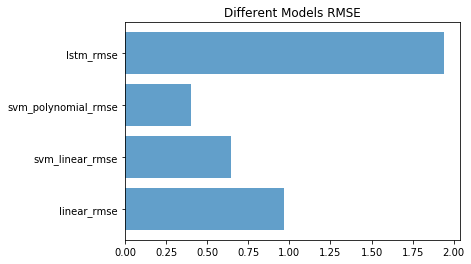

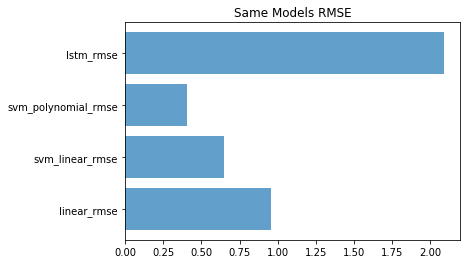

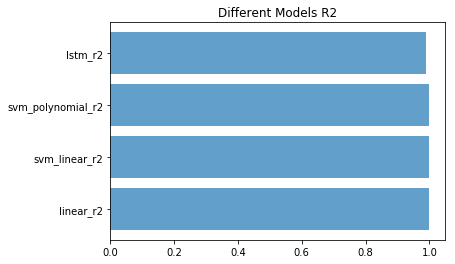

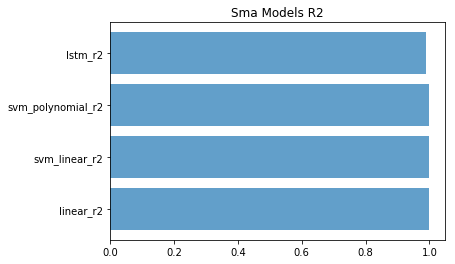

In [22]:
#plot rmse of methods
def plot_method(frame, method, title):
    #drop r2 columns
    cols = [c for c in frame.columns if method in c]
    rmse_results =frame[cols]
    plot_bar(title, rmse_results)

def plot_bar(title, dataframe):
    df = dataframe.mean(axis=0)
    objects = dataframe.columns
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, df , align='center', alpha=0.7)
    plt.yticks(y_pos, objects)
    #plt.xlabel(title)
    plt.title(title)
    plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 60))


plot_method(results_different_models, "rmse", "Different Models RMSE")
plot_method(result_same_models, "rmse", "Same Models RMSE")

plot_method(results_different_models, "r2", "Different Models R2")
plot_method(result_same_models, "r2", "Sma Models R2")